<a href="https://colab.research.google.com/github/kurokaj/Music-Generation/blob/main/CONLON_WAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installs and imports

print('Installing dependencies...')
!pip install pypianoroll
!pip install muspy

!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!pip install midi2audio
from midi2audio import FluidSynth
from IPython.display import Audio


Installing dependencies...
     |████████████████████████████████| 5.6MB 33.7MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp37-none-any.whl size=5591958 sha256=16adda625230d033dcdc1e79b19f20a92b0ae14ad96f0da631bf1f1de01e8c68
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pretty-midi
     |████████████████████████████████| 102kB 10.5MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 39 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB

In [ ]:
# Imports
import math
import random
random.seed(13)
from math import ceil
from random import shuffle
import numpy as np 
import seaborn as sns
import torch
import pandas as pd
import matplotlib.pyplot as  plt 
from mpl_toolkits import mplot3d
import pypianoroll as pr
import os 
import pretty_midi
import librosa
import muspy 
import music21
from tqdm.notebook import tqdm
muspy.download_musescore_soundfont()

import torch
import torch.nn as nn 
import torch.nn.functional as F
from torchsummary import summary
from torch.autograd import Variable


if torch.cuda.is_available():
  print("GPU is available")
  device = torch.device("cuda")
else:
  print("GPU is NOT available")
  device = torch.device("cpu")

Start downloading MuseScore General soundfont.
MuseScore General soundfont has successfully been downloaded to : /root/.muspy/musescore-general.
GPU is available


In [ ]:
# get the data to processable form

path_to_clips = "/content/drive/My Drive/AI/music_wae/ASF-4"

file_list = os.listdir(path_to_clips)

# List for all the clips to use
music_list = []
# List for all 4- instrument clips to annotate (pitch shift)
#music_list_all4 = []
# To get the labels of each clip
labels_list = []

amount = 0
for p in tqdm(file_list):
  path_j = os.path.join(path_to_clips, p)
  music = muspy.read_midi(path_j)
  # take only one instrument 
  #instruments = [t.name for t in music.tracks]
  #if  len(instruments) >= 3:
  music_list.append(music)

# Get clips with 4 instruments
  # Due to the mutable quality of python it has to be done in separate loop

#for p in tqdm(file_list):
#  path_j = os.path.join(path_to_clips, p)
#  music = muspy.read_midi(path_j)
#  # take only one instrument 
#  instruments = [t.name for t in music.tracks]
#  if len(instruments) == 4:
#        music_list_all4.append(music.copy())

print(len(music_list))
#print(len(music_list_all4))


 #  music.tracks = [tup for tup in music.tracks if (tup.name == "Bass track")]
    #music.tracks = [tup for tup in music.tracks if (tup.is_drum)] 
     #if amount == 5:
  #  break
  #amount= amount+1


910


In [ ]:
# Function to play Midi-file

def play_clip(clip, name="/content/drive/My Drive/AI/music_wae/saved_clip"):
  """ Input : muspy-class midi file
              name of the midi-file
  """
  path_mid = os.path.join("",(name+".mid"))
  path_audio = os.path.join("",(name+".wav"))
  ret = muspy.write_midi(path_mid, clip)
  FluidSynth("font.sf2").midi_to_audio(path_mid, path_audio)
  return Audio(path_audio)
  

In [ ]:
# Function to plot the processed pianorolls

def plot_processed_roll(array, bar=1):
  """ Input:  array = 2,128,55
      bar = the number of bar wanted to be plot (1 is the first)
  """

  fig, ax = plt.subplots(1,2 , figsize=(25,25)) 

  for l in range(0,2):

    layer = array[l,:,:]
    d = layer.astype('str')
    start_t = 32*(bar-1)
    end_t = 32*bar
    d = d[:,start_t:end_t]

    # Highest and lowest pitch
    for low_pitch in range(0, d.shape[0]):
      if not(np.all(d[low_pitch,:]=='0.0')):
          break

    for high_pitch in range(d.shape[0]-1, 0, -1):
      if not(np.all(d[high_pitch,:]=='0.0')):
          break 

    # D range to be plotted = highest and lowest pitch + 1
    d = d[low_pitch-1:high_pitch+2, :]
    p = d.shape[0]
    
    color = np.copy(d)
    np.putmask(color, color=='0.0', "w")
    np.putmask(color, color!='w', "y") 

    pitch = [str(i) for i in range(low_pitch-1, high_pitch+2)]
    time_np = np.arange(start_t,end_t).astype('str')
    time = list(time_np) 

    ax[l].set_axis_off()
    
    table = ax[l].table( 
        cellText = list(d),  
        rowLabels = pitch,  
        colLabels = time, 
        rowColours =["palegreen"] * p,  
        colColours =["palegreen"] * 32, 
        cellColours = color,
        cellLoc ='center',  
        loc ='upper left')         
      
  plt.show() 



None 16
Bass track 39
(7567, 128)


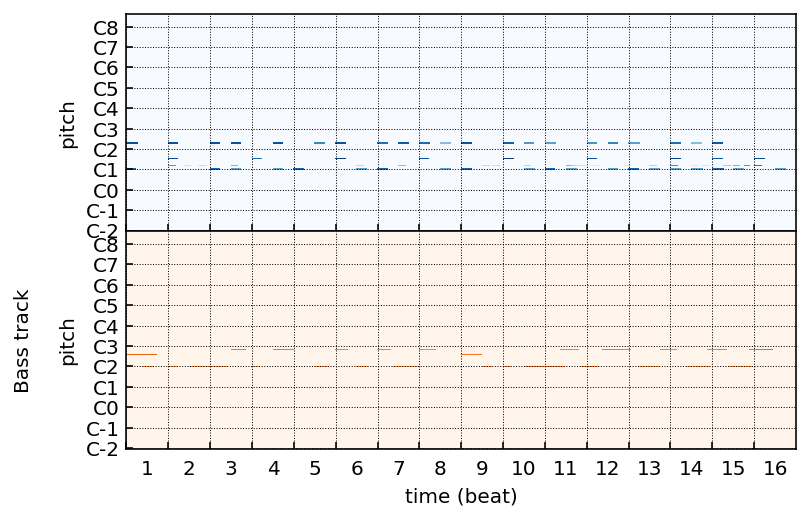

In [ ]:
# Visualize the pianorolls and shapes
m0 = music_list[0]
#m1 = music_list[2]
#mlast = music_list[3]

# drums = 16, bass=39, rhodes= 4, hammond=17
for t in m0.tracks:
  print(t.name ,t.program)

pianor=muspy.to_pianoroll_representation(m0)
#pianor1=muspy.to_pianoroll_representation(m1)
#pianor2=muspy.to_pianoroll_representation(mlast)

print(pianor.shape)
#print(pianor1.shape)
#print(pianor2.shape)

#print(mlast)

muspy.show_pianoroll(m0) 
#muspy.show_pianoroll(m1)
#muspy.show_pianoroll(mlast)



In [ ]:
def create_hist(m_list):
  num_tracks = []
  note_len = []
  notedur = []
  p_drums = []
  p_bass = []
  p_others = []
  velocity = []

  # calculate clips that have dur over 80
  clipsDurOver80 = 0
  # plot histograms of duration per each instrument
  durDrums = []
  durBass = []
  durRhodes = []
  durHammond = []

  # drums = 16, bass=39, rhodes= 4, hammond=17
  programs=[16,39,4,17]

  for idx,clip in enumerate(m_list):
    num_tracks.append(len(clip.tracks))
    # calculate clips that have dur over 80
    durOver80 = False
    for track in clip.tracks:
     
      for n in track.notes:
        
        if round(n.duration/60) > 80:
          durOver80 = True

        velocity.append(n.velocity)

        if track.is_drum:
          p_drums.append(n.pitch)
          durDrums.append(round(n.duration/60))
        elif track.name == "Bass track" or track.program == 39:
          p_bass.append(n.pitch)
          durBass.append(round(n.duration/60))
        else:
          p_others.append(n.pitch)
          if track.name == "Rhodes track" or track.program == 4:
            durRhodes.append(round(n.duration/60))
          elif track.name == "Hammond track" or track.program == 17:
            durHammond.append(round(n.duration/60))


        notedur.append(round(n.duration/60))
        temp = n.duration % 60
        note_len.append(temp)
    if durOver80:
      clipsDurOver80 = clipsDurOver80 + 1

  # Change all zeros to 1
  for nd in range(0, len(notedur)):
    if notedur[nd] == 0:
      notedur[nd] = 1

  MAX_d = max(notedur)
  MIN_d = min(notedur)
  MAX_v = max(velocity)
  MIN_v = min(velocity)
  MAX_p = max(p_others)
  MIN_p = min(p_others)

  print("Max velocity:", MAX_v)
  print("Min velocity:", MIN_v)
  print("Max duration:", MAX_d)
  print("Min duration:", MIN_d)
  print("Max pitch:", MAX_p)
  print("Min pitch:", MIN_p)
  print("Tracks that have notes over 80 is: ", clipsDurOver80)

  plt.hist(velocity)
  plt.title("The distribution of velocities")
  plt.show()

  plt.hist(num_tracks)
  plt.title("Number of tracks in clips")
  plt.show()

  #plt.hist(note_len, bins=100)
  #plt.title("Histogram of note duration % 60")
  #plt.show()

  plt.hist(notedur, bins=100)
  plt.title("Histogram of quantisized note duration")
  plt.show()

  #plt.hist(durDrums)
  #plt.title("The distribution of drum durations")
  #plt.show()

  #plt.hist(durBass)
  #plt.title("The distribution of bass durations")
  #plt.show()

  #plt.hist(durRhodes)
  #plt.title("The distribution of rhodes durations")
  #plt.show()

  #plt.hist(durHammond)
  #plt.title("The distribution of hammond durations")
  #plt.show()

  fig, axs = plt.subplots(3, sharex=True)
  plt.subplots_adjust(hspace=0.5)
  fig.suptitle('Pitches per instrument')
  axs[0].hist(p_drums,100)
  axs[0].set_title('Drum pitches')
  axs[1].hist(p_bass,100)
  axs[1].set_title('Bass pitches')
  axs[2].hist(p_others,100)
  axs[2].set_title('Other pitches')
  plt.show()

  #print(max(p_others))



Max velocity: 127
Min velocity: 1
Max duration: 128
Min duration: 1
Max pitch: 83
Min pitch: 36
Tracks that have notes over 80 is:  34


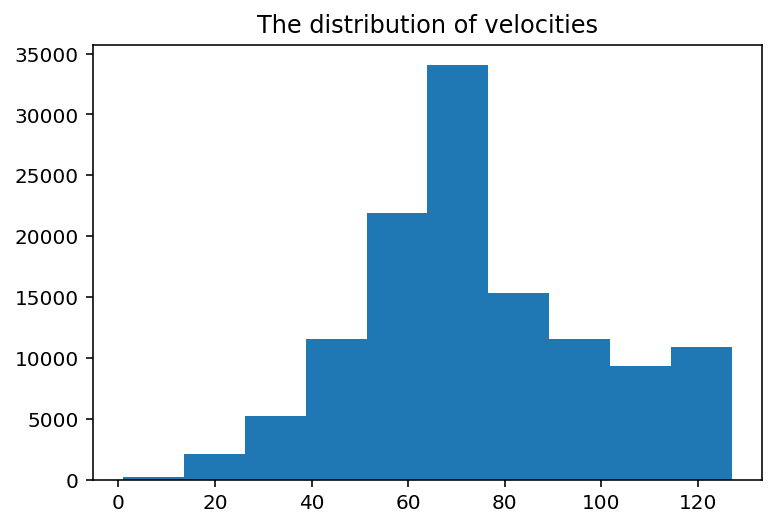

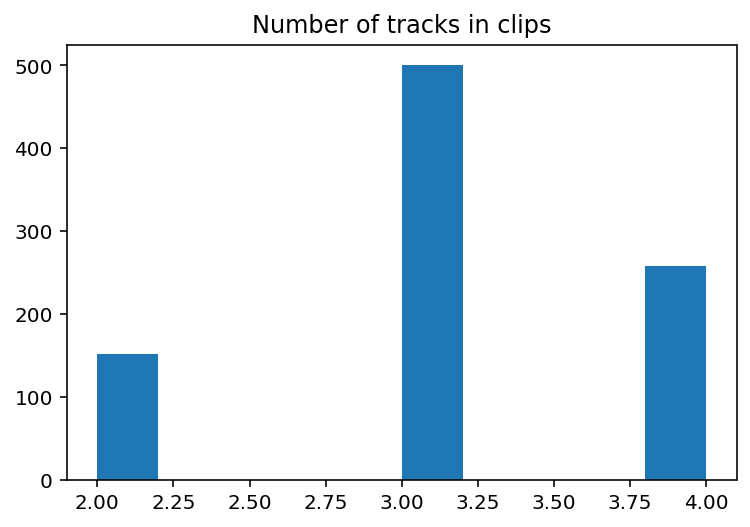

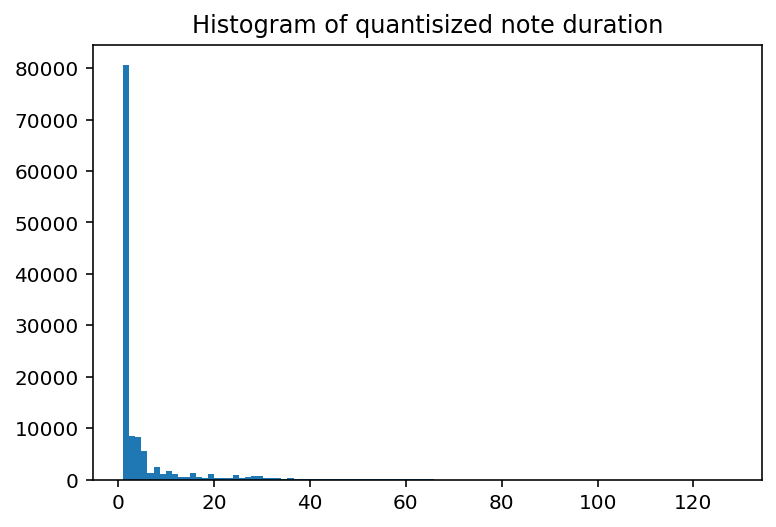

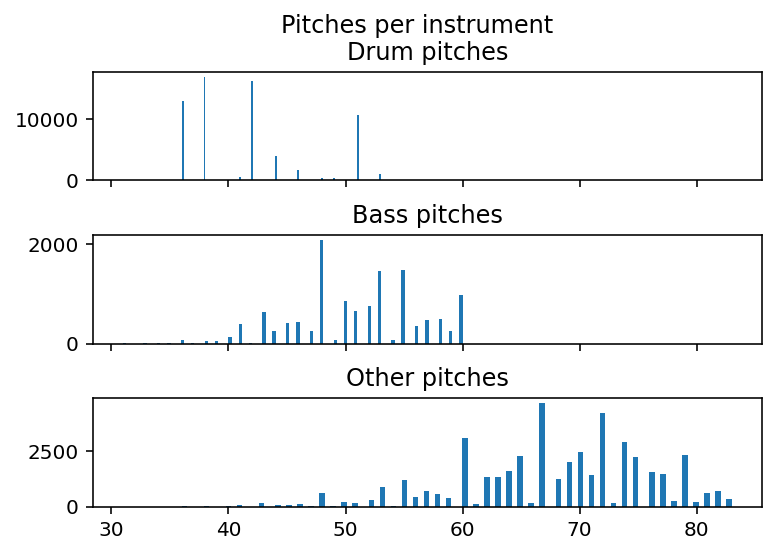

In [ ]:
# Create histograms for visualization BEFORE TRANSPOSITION
create_hist(music_list)
#create_hist(music_list_train)
#create_hist(music_list_test)

## Augmentation

8


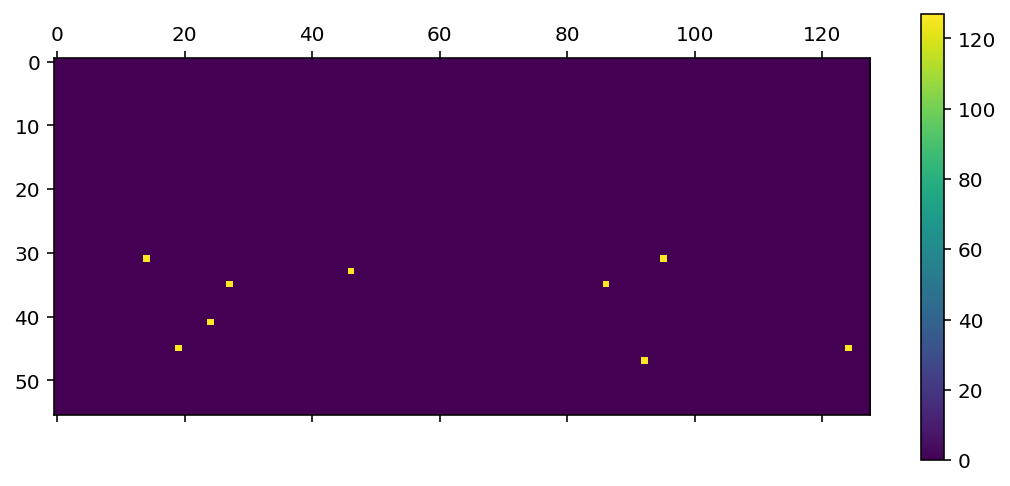

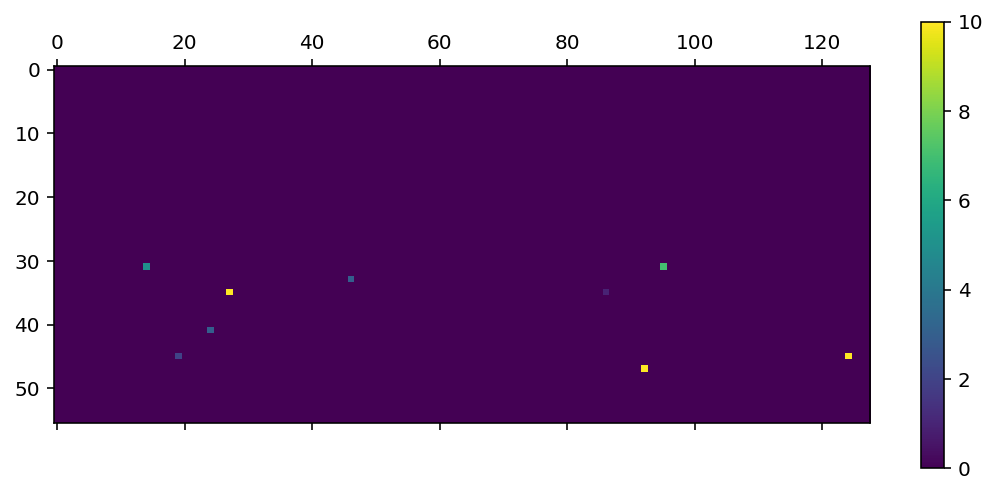

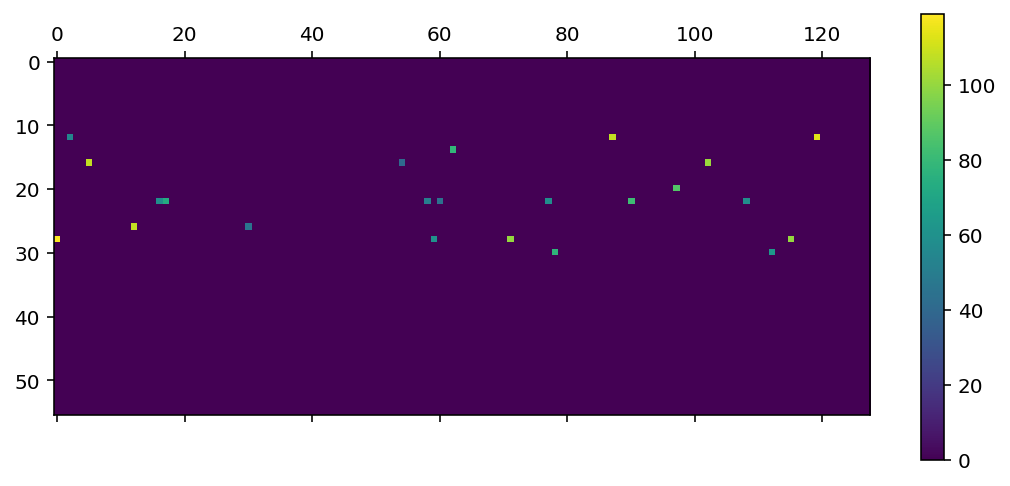

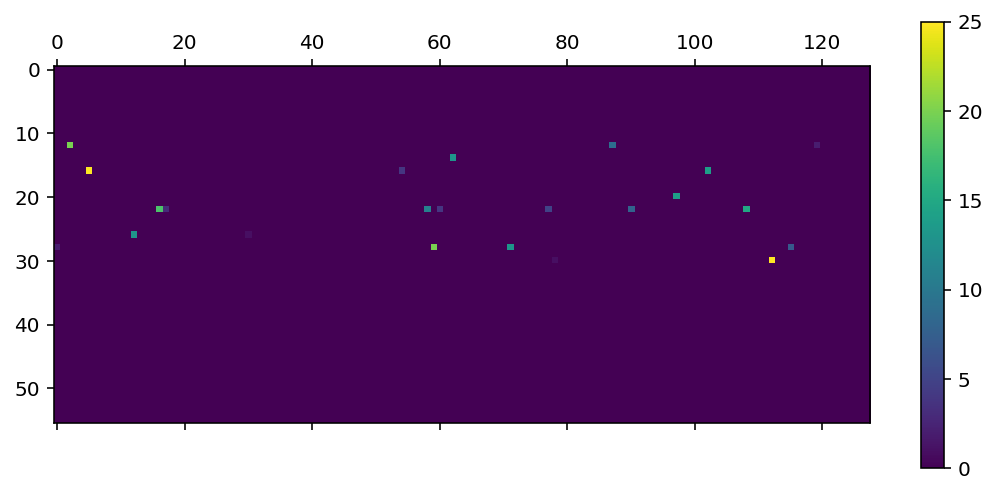

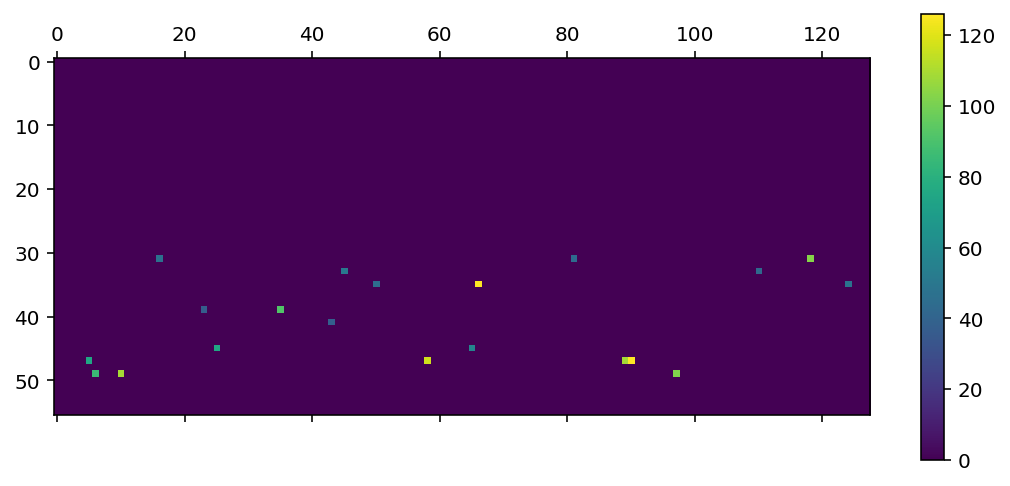

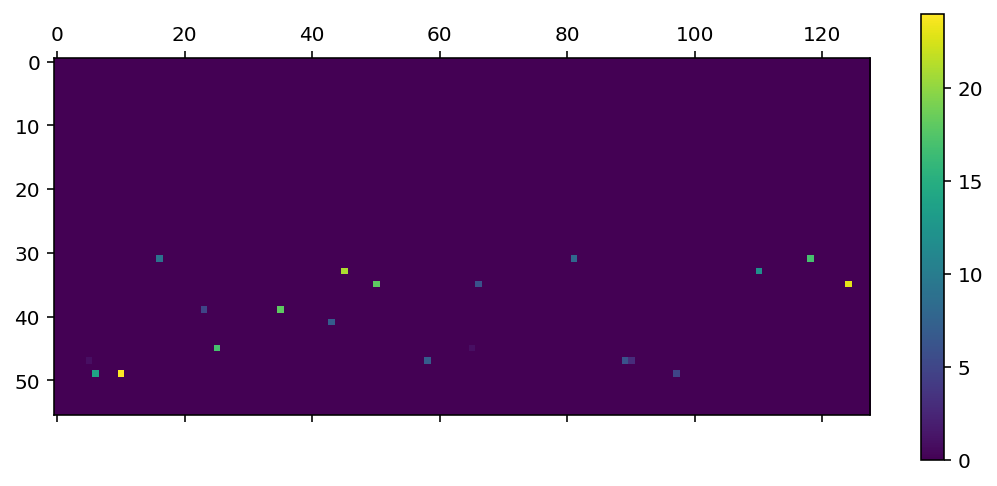

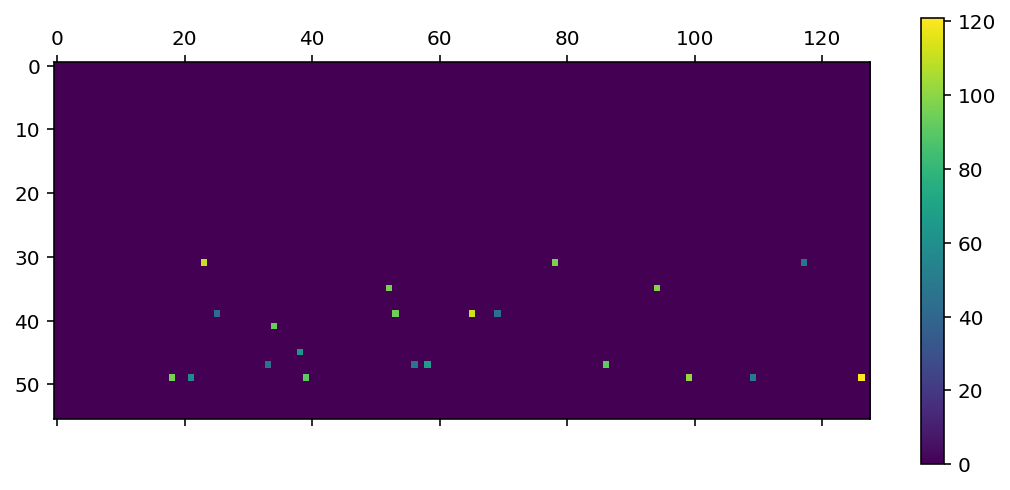

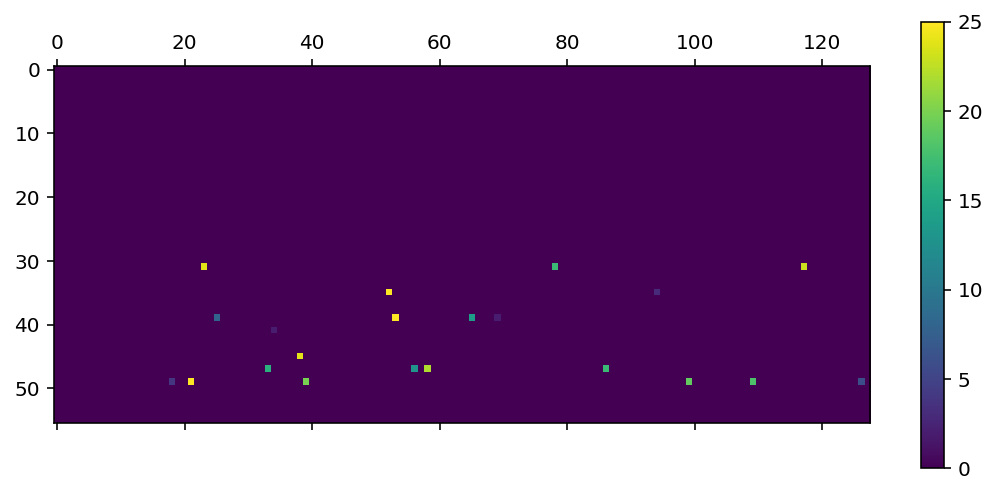

(56, 128) (56, 128)
(56, 128) (56, 128)
(56, 128) (56, 128)
(56, 128) (56, 128)
(56, 128) (56, 128)
(56, 128) (56, 128)
(56, 128) (56, 128)
(56, 128) (56, 128)
Music(metadata=Metadata(schema_version='0.0'), resolution=480, tracks=[Track(program=16, is_drum=True, notes=[Note(time=840, pitch=31, duration=300, velocity=127), Note(time=1140, pitch=45, duration=120, velocity=127), Note(time=1440, pitch=41, duration=180, velocity=127), ...]), Track(program=39, is_drum=False, notes=[Note(time=0, pitch=58, duration=120, velocity=119), Note(time=120, pitch=42, duration=1200, velocity=54), Note(time=300, pitch=46, duration=1500, velocity=108), ...]), Track(program=4, is_drum=False, notes=[Note(time=300, pitch=77, duration=60, velocity=75), Note(time=360, pitch=79, duration=840, velocity=86), Note(time=600, pitch=79, duration=1440, velocity=109), ...]), ...])
Music(metadata=Metadata(schema_version='0.0'), resolution=480, tracks=[Track(program=16, is_drum=True, notes=[Note(time=840, pitch=31, dura

NameError: ignored

In [ ]:
# Create random notes base clip
import random

times = 20

tensor_base = []

drums = np.zeros(shape=(2,56,128),dtype=np.float64)
bass = np.zeros(shape=(2,56,128),dtype=np.float64)
rhodes = np.zeros(shape=(2,56,128),dtype=np.float64)
hammond = np.zeros(shape=(2,56,128),dtype=np.float64)

pitch_change = [-9,-7,-5,-1,1,5,7,9]

drum_start = [random.randrange(0,6) for i in range(127)]
for idx,start in enumerate(drum_start):
  if start == 0:
    drum_pitch = 40 + random.choice(pitch_change)
    drums[0][drum_pitch][idx] = 127
    drums[1][drum_pitch][idx] = random.randint(0,10)

bass_start = [random.randrange(0,6) for i in range(127)]
for idx,start in enumerate(bass_start):
  if start == 0:
    bass_pitch = 21 + random.choice(pitch_change)
    bass[0][bass_pitch][idx] = random.randint(40,128)
    bass[1][bass_pitch][idx] = random.randint(1,25)

rhodes_start = [random.randrange(0,7) for i in range(127)]
for idx,start in enumerate(rhodes_start):
  if start == 0:
    rhodes_pitch = 40 + random.choice(pitch_change)
    rhodes[0][rhodes_pitch][idx] = random.randint(37,127)
    rhodes[1][rhodes_pitch][idx] = random.randint(1,25)

hammond_start = [random.randrange(0,7) for i in range(127)]
for idx,start in enumerate(hammond_start):
  if start == 0:
    hammond_pitch = 40 + random.choice(pitch_change)
    hammond[0][hammond_pitch][idx] = random.randint(40,127)
    hammond[1][hammond_pitch][idx] = random.randint(1,25)

# Stack vel and dur 
all_8 = np.concatenate((drums,bass), axis=0)
all_8 = np.concatenate((all_8, rhodes), axis=0)
all_8 = np.concatenate((all_8, hammond), axis=0)
# Remember to stack the channels to produce the final Matrix 128x55x8

# Append a tuple of all_8 and label
tensor_base.append(all_8)
tensor_base = np.array(tensor_base[0])

print(len(tensor_base))

#clip_show = inv_tr_clip
clip_show = tensor_base
#clip_show = clip_in[0][:][:][:]
plt.matshow(clip_show[0][:][:])
plt.colorbar()
plt.show()
plt.matshow(clip_show[1][:][:])
plt.colorbar()
plt.show()

plt.matshow(clip_show[2][:][:])
plt.colorbar()
plt.show()
plt.matshow(clip_show[3][:][:])
plt.colorbar()
plt.show()

plt.matshow(clip_show[4][:][:])
plt.colorbar()
plt.show()
plt.matshow(clip_show[5][:][:])
plt.colorbar()
plt.show()

plt.matshow(clip_show[6][:][:])
plt.colorbar()
plt.show()
plt.matshow(clip_show[7][:][:])
plt.colorbar()
plt.show()



instruments=["Drum track", "Bass track", "Rhodes track", "Hammond track"]
programs=[16,39,4,17]
flag = 0
whole_clip = []

# Stack 20 of these
for time in range(0,20):
  muspy_obj = muspy.Music(resolution=480) # Might need to be added something more
  for i,instr in enumerate(instruments):
      t = i*2
      track = tensor_base[t:t+2]

      # multiply v with d and see which values are not 0 -> true events
      # Loop true events and apply gamma correction based on the instrument list
      note_based_representation = []
      print(track[0].shape, track[1].shape)
      mask_pitch, mask_time = np.nonzero(track[0] * track[1])

      for event in range(mask_pitch.shape[0]):
        # Pitches were quantizised by 30 in every track except drums (testing drums moving)
        if instr=="Drum track":
          pitch = mask_pitch[event] 
        else: 
          pitch = mask_pitch[event] + 30
        # TIME ADDED HERE
        start_time = mask_time[event] * 60
        duration = track[1][mask_pitch[event]][mask_time[event]] * 60

        velocity = track[0][mask_pitch[event]][mask_time[event]]

        # Add note to list
          # Also scale the timing based on the index (time) of the clip
        note = (start_time+(time*128*60), pitch, duration,velocity)
        note_based_representation.append(note)

      # Convert note based format to muspy class
      note_based_track = np.array(note_based_representation)
      
      if instr == "Drum track":
        muspy_track = muspy.from_note_representation(note_based_track, resolution=480, program=programs[i], 
                                    is_drum=True, use_start_end=False,
                                    encode_velocity=True, default_velocity=64)
      else:
        muspy_track = muspy.from_note_representation(note_based_track, resolution=480, program=programs[i], 
                                    is_drum=False, use_start_end=False,
                                    encode_velocity=True, default_velocity=64)
      
      whole_clip.append(muspy_track)
      muspy_obj.tracks.append(muspy_track.tracks[0])

  if flag == 0:
    song = muspy_obj
    flag = 1
  else:
    for i in range(4):
      print(song)
      song.tracks[i].notes.extend(muspy_obj.tracks[i].notes)
    




play_clip(song)




In [ ]:
# Augment data here
  # Do pitch shift 
    # To those clips that have 4 instruments and long notes
    # Not changing drum spots ??? Is this good practise??
    # Random shift range [-3 , 2]

# Use like 30% notes 2/5/7 semitones

pitch_change = [-9,-7,-5,-1,1,5,7,9] # check that note does not go out of bounds!!!
for c4 in music_list_all4:
  for track in c4.tracks:
    if not(track.is_drum):
      numberOfNotes = len(track.notes)
      indexesToChange = random.sample(range(0, numberOfNotes), round(numberOfNotes*0.3))
      for noteIdx in indexesToChange:
        transpositionValue = random.choice(pitch_change)
        if ((track.notes[noteIdx].pitch + transpositionValue) < 85):
          track.notes[noteIdx].transpose(transpositionValue)
  
        
print(len(music_list_all4))

music_list = music_list + music_list_all4[:-2]
print(len(music_list))


In [ ]:
# Loop trhough music list and delete instances that have duration of 80 or more
idx_to_delete = []

for idx,clip in enumerate(music_list):
    # calculate clips that have dur over 80
    over80 = False
    for track in clip.tracks:
      for n in track.notes:
        if round(n.duration/60) > 80:
          over80 = True
    # This so that we do not have duplicate instances
    if over80:
      idx_to_delete.append(idx)
        
print(idx_to_delete)

for index in sorted(idx_to_delete, reverse=True):
    del music_list[index]

amount_deleted = len(idx_to_delete)
print("Amount of deleted clips", amount_deleted)
print("Amount of clips left", len(music_list))

[16, 22, 37, 75, 93, 96, 107, 123, 128, 155, 207, 338, 339, 373, 376, 408, 458, 494, 519, 624, 625, 657, 665, 729, 748, 763, 766, 787, 802, 818, 833, 836, 879, 909]
Amount of deleted clips 34
Amount of clips left 876


## Transposition

910
Max velocity: 127
Min velocity: 1
Max duration: 128
Min duration: 1
Max pitch: 53
Min pitch: 6
Tracks that have notes over 80 is:  34


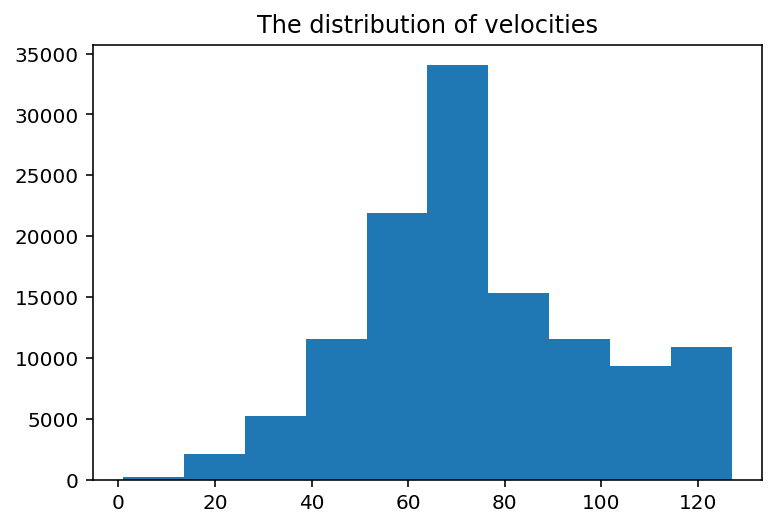

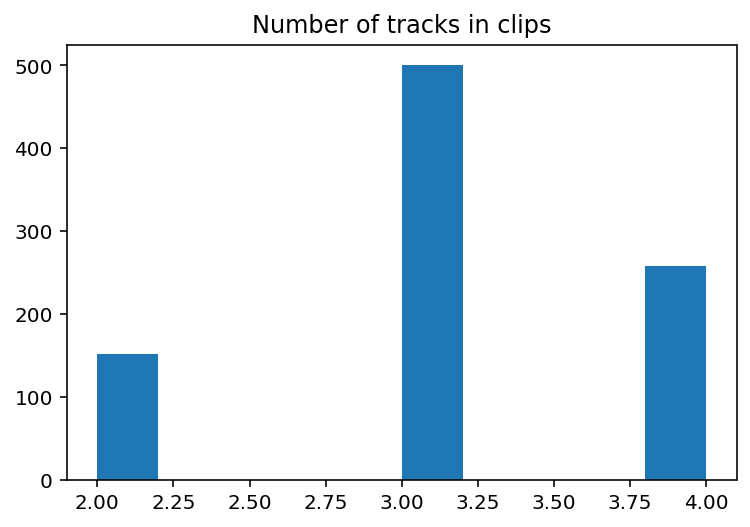

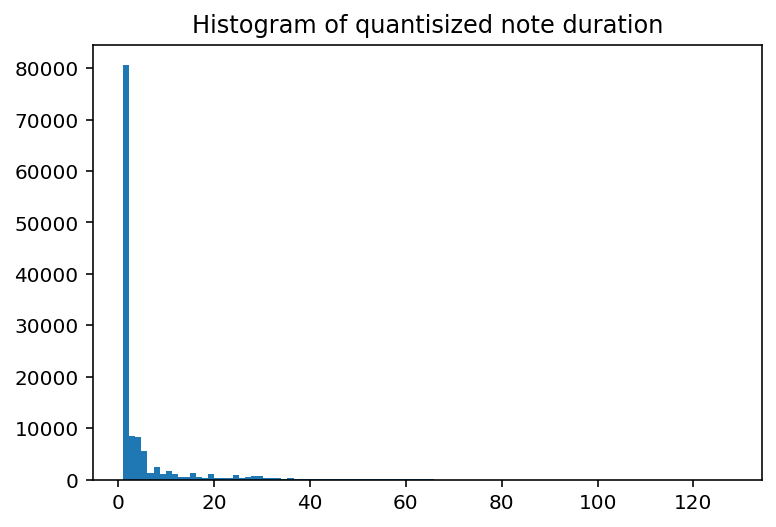

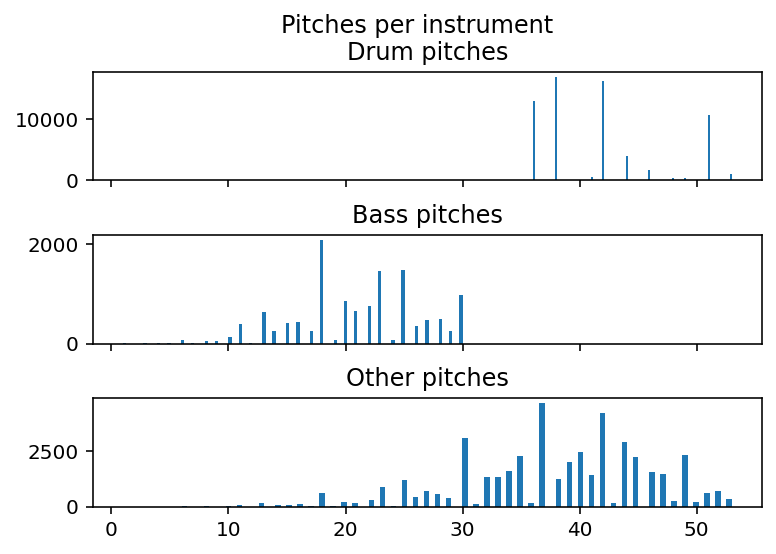

In [ ]:
# Map the pitches and do the root note transposition in the clips 

#transposed_music_train = music_list_train.copy()
transposed_music_list = music_list.copy()

print(len(transposed_music_list))

for clip in transposed_music_list:
  for track in clip.tracks:
    if not(track.is_drum):
      track.transpose(-30)

#for clip in transposed_music_test:
#  for track in clip.tracks:
#    if not(track.is_drum):
#      track.transpose(-30)

#create_hist(transposed_music_train)
create_hist(transposed_music_list)


## Min Max Scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Output can also be mapped to normal. Now is uniform
mms_d = MinMaxScaler(feature_range=(-1,1))
mms_v = MinMaxScaler(feature_range=(-1,1))

#pt = PowerTransformer(method='box-cox', standardize=False)

# Train the quantile transformer and print the histogram of the durations
durations = []
velocities = []

for idx,clip in enumerate(transposed_music_list):
  # Loop tracks 
  for track in clip.tracks:
    # Loops notes
    for n in track.notes:
        # Put all drum durations to 1
        if track.is_drum:
          d=1
        else:
          d = round(n.duration/60)
        durations.append(d)
        velocities.append(n.velocity)

# Change all zeros to 1
#for nd in range(0, len(durations)):
#  if durations[nd] == 0:
#    durations[nd] = 1

# Append zeros so that the scaling will be 0 -> -1
# NB! Scaling max is different in both d->128 and v->127
for i in range(0,100):
  durations.append(0)
for i in range(0,100):
  velocities.append(0)
print("Added 1000 0's to durations and 800 0's to velocities so that 1 does not map to zero.")

# delete 50 000 instances of 1 (smoothen the distribution a bit)
temp = 0
# amount 1 = 69083
# amount 2 = 14650
# amount 3 = 8053

#for i in durations:
  #if i == 1:
    #temp += 1 
    #durations.remove(i)
  #if temp == 50000:
    #break


plt.hist(durations, bins=80)
plt.title("Histogram of all note durations")
plt.show()

plt.hist(velocities, bins=128)
plt.title("Histogram of all note velocities")
plt.show()

print("**************** Transformation **************")

print("Performing quantile transformation")
durations = np.expand_dims(np.array(durations),1)
print(durations.shape)
velocities = np.expand_dims(np.array(velocities),1)
print(velocities.shape)

durations_transformed_quantile = mms_d.fit_transform(durations)
velocities_transformed_quantile = mms_v.fit_transform(velocities)

plt.hist(durations_transformed_quantile, bins=20)
plt.title("Histogram of quantile transformed all note durations")
plt.show()

plt.hist(velocities_transformed_quantile, bins=10)
plt.title("Histogram of quantile transformed all note velocities")
plt.show()


print("**************** Transform back and plot histogram **************")

durations_transformed_quantile_back = mms_d.inverse_transform(durations_transformed_quantile)
plt.hist(durations_transformed_quantile_back, bins=80)
plt.title("Histogram of durations inverse transformed (supposed to look original)")
plt.show()

velocities_transformed_quantile_back = mms_v.inverse_transform(velocities_transformed_quantile)
plt.hist(velocities_transformed_quantile_back, bins=128)
plt.title("Histogram of velocities inverse transformed (supposed to look original)")
plt.show()

test = 1
print("D", str(test),"in this transformation is: ", mms_d.transform([[test]]))
print("V", str(test),"in this transformation is: ", mms_v.transform([[test]]))

test4 = 0
print("D", str(test4),"in transformation is: ", mms_d.transform([[test4]]))
print("V", str(test4),"in transformation is: ", mms_v.transform([[test4]]))

test5 = 2
print("D", str(test5),"in transformation is: ", mms_d.transform([[test5]]))
print("V", str(test5),"in transformation is: ", mms_v.transform([[test5]]))

test2 = -0.98
print("D", str(test2),"in inverse transformation is: ", mms_d.inverse_transform([[test2]]))
print("V", str(test2),"in inverse transformation is: ", mms_v.inverse_transform([[test2]]))

test3 = -1
print("D", str(test3),"in inverse transformation is: ", mms_d.inverse_transform([[test3]]))
print("V", str(test3),"in inverse transformation is: ", mms_v.inverse_transform([[test3]]))


## Transformation and data division

Rhodes track got zero note
Rhodes track got zero note
Rhodes track got zero note
Bass track got zero note
Rhodes track got zero note
Hammond track got zero note
Hammond track got zero note
Rhodes track got zero note
Rhodes track got zero note
Rhodes track got zero note
Bass track got zero note
Bass track got zero note
Hammond track got zero note
Added 1000 0's to durations and 800 0's to velocities so that 1 does not map to zero.


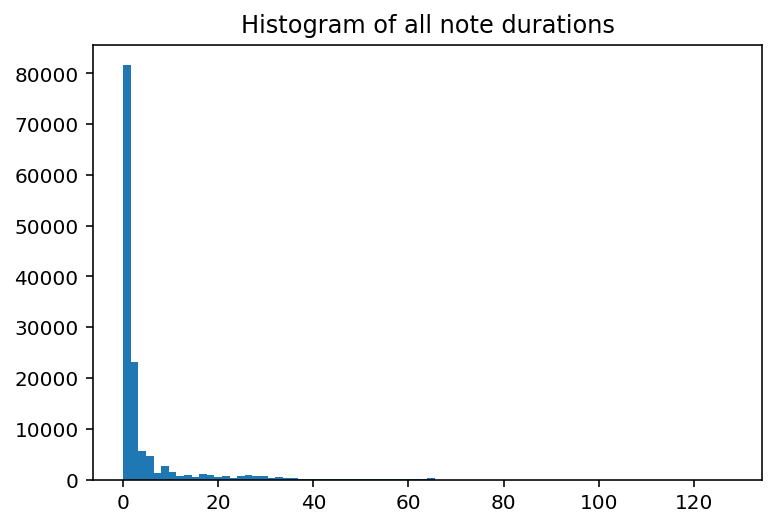

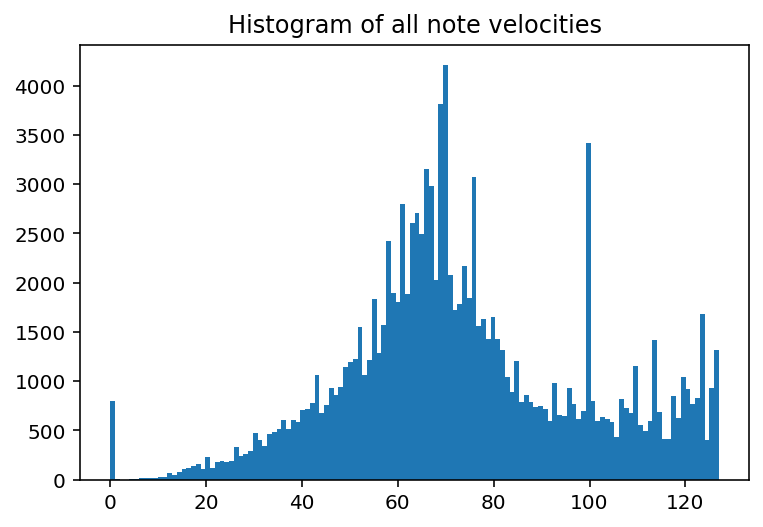

**************** Transformation **************
Performing quantile transformation
(132205, 1)
(123005, 1)


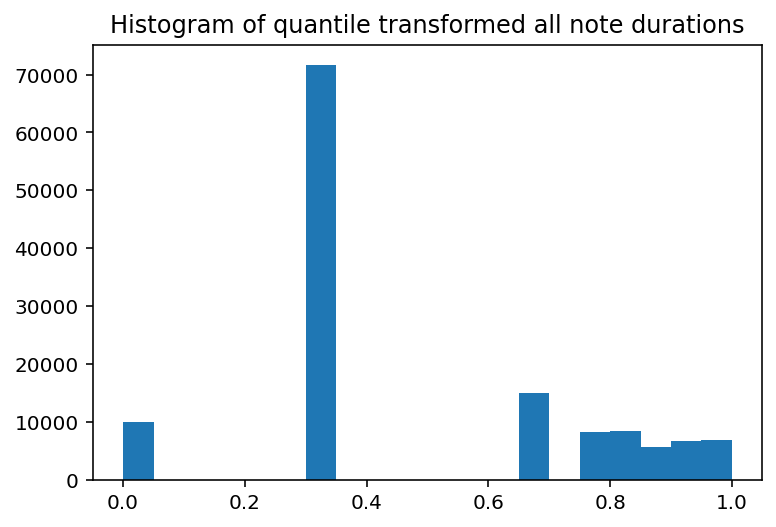

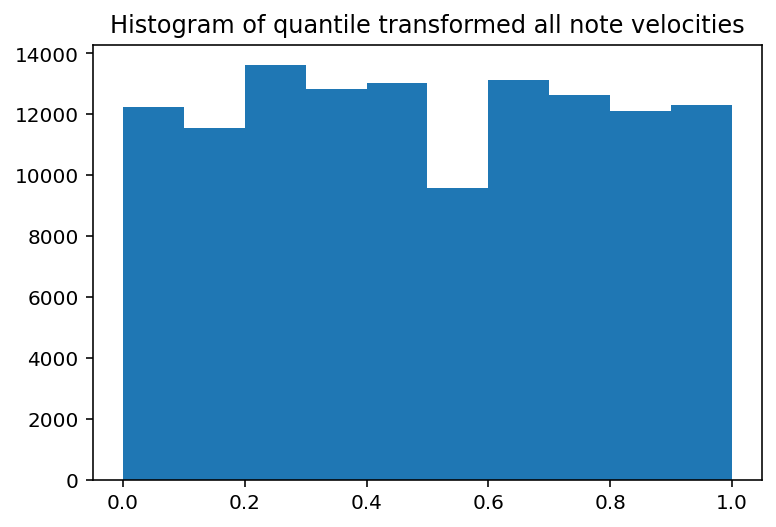

**************** Transform back and plot histogram **************


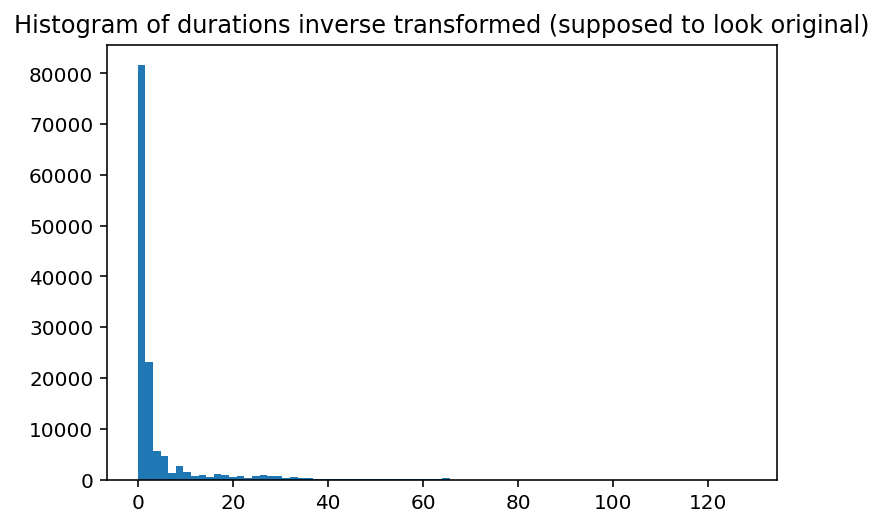

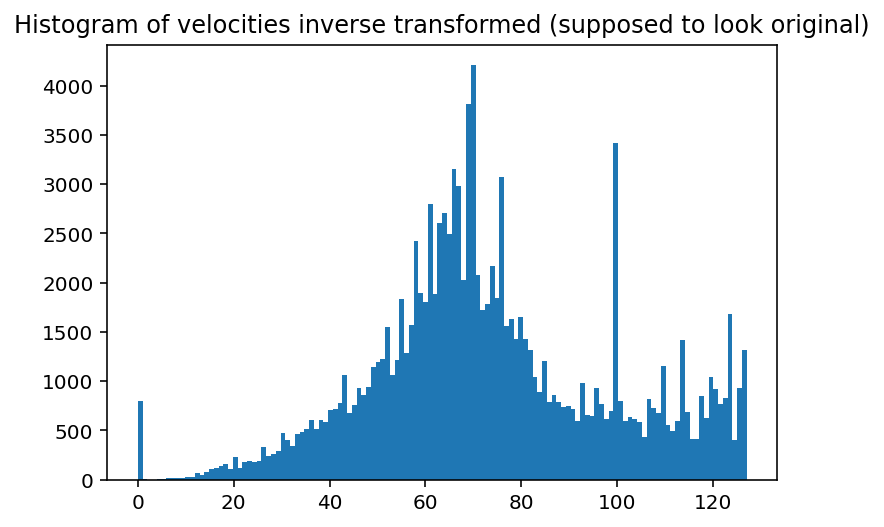

D 1 in this transformation is:  [[0.34684685]]
V 1 in this transformation is:  [[0.00611723]]
D 0 in transformation is:  [[0.]]
V 0 in transformation is:  [[0.]]
D 2 in transformation is:  [[0.67417417]]
V 2 in transformation is:  [[0.00622845]]
D 0.18 in inverse transformation is:  [[1.]]
V 0.18 in inverse transformation is:  [[53.]]
D 0 in inverse transformation is:  [[0.]]
V 0 in inverse transformation is:  [[0.]]


In [ ]:
from sklearn.preprocessing import QuantileTransformer

# Output can also be mapped to normal. Now is uniform
qt_d = QuantileTransformer(random_state=0)
qt_v = QuantileTransformer(random_state=0)

#pt = PowerTransformer(method='box-cox', standardize=False)

# Train the quantile transformer and print the histogram of the durations
durations = []
velocities = []

for idx,clip in enumerate(transposed_music_list):
  # Loop tracks 
  for track in clip.tracks:
    # Loops notes
    for n in track.notes:
        # Put all drum durations to 1
        if track.is_drum:
          d=1
        else:
          d = round(n.duration/60)
        
        if d == 0:
          d = 1
          print(track.name + " got zero note")

        durations.append(d)
        velocities.append(n.velocity)

# Change all zeros to 1
#for nd in range(0, len(durations)):
#  if durations[nd] == 0:
#    durations[nd] = 1

for i in range(0,10000):
  durations.append(0)
for i in range(0,800):
  velocities.append(0)
print("Added 1000 0's to durations and 800 0's to velocities so that 1 does not map to zero.")

# delete 50 000 instances of 1 (smoothen the distribution a bit)
temp = 0
# amount 1 = 69083
# amount 2 = 14650
# amount 3 = 8053

#for i in durations:
  #if i == 1:
    #temp += 1 
    #durations.remove(i)
  #if temp == 50000:
    #break


plt.hist(durations, bins=80)
plt.title("Histogram of all note durations")
plt.show()

plt.hist(velocities, bins=128)
plt.title("Histogram of all note velocities")
plt.show()


print("**************** Transformation **************")

print("Performing quantile transformation")
durations = np.expand_dims(np.array(durations),1)
print(durations.shape)
velocities = np.expand_dims(np.array(velocities),1)
print(velocities.shape)

durations_transformed_quantile = qt_d.fit_transform(durations)
velocities_transformed_quantile = qt_v.fit_transform(velocities)

plt.hist(durations_transformed_quantile, bins=20)
plt.title("Histogram of quantile transformed all note durations")
plt.show()

plt.hist(velocities_transformed_quantile, bins=10)
plt.title("Histogram of quantile transformed all note velocities")
plt.show()


print("**************** Transform back and plot histogram **************")

durations_transformed_quantile_back = qt_d.inverse_transform(durations_transformed_quantile)
plt.hist(durations_transformed_quantile_back, bins=80)
plt.title("Histogram of durations inverse transformed (supposed to look original)")
plt.show()

velocities_transformed_quantile_back = qt_v.inverse_transform(velocities_transformed_quantile)
plt.hist(velocities_transformed_quantile_back, bins=128)
plt.title("Histogram of velocities inverse transformed (supposed to look original)")
plt.show()

test = 1
print("D", str(test),"in this transformation is: ", qt_d.transform([[test]]))
print("V", str(test),"in this transformation is: ", qt_v.transform([[test]]))

test4 = 0
print("D", str(test4),"in transformation is: ", qt_d.transform([[test4]]))
print("V", str(test4),"in transformation is: ", qt_v.transform([[test4]]))

test5 = 2
print("D", str(test5),"in transformation is: ", qt_d.transform([[test5]]))
print("V", str(test5),"in transformation is: ", qt_v.transform([[test5]]))

test2 = 0.18
print("D", str(test2),"in inverse transformation is: ", qt_d.inverse_transform([[test2]]))
print("V", str(test2),"in inverse transformation is: ", qt_v.inverse_transform([[test2]]))

test3 = 0
print("D", str(test3),"in inverse transformation is: ", qt_d.inverse_transform([[test3]]))
print("V", str(test3),"in inverse transformation is: ", qt_v.inverse_transform([[test3]]))

In [ ]:
# Take only the one clip
#temp = 0
#for music in transposed_music_list:
#  if music.metadata.source_filename == "Soul_Rehab_Main_1.mid":
#    temp = music

#transposed_music_list = [temp]
#for t in range(0,0):
#  transposed_music_list.append(temp)

#print(len(transposed_music_list))

In [ ]:
# generate the numpy arrays that can be transformed to tensors
  
def get_label(clip):
  string = clip.metadata.source_filename
  idx_last_us = ([pos for pos, char in enumerate(string) if char == "_"])[1]
  label = string[:idx_last_us]
  return label
  

tensor_list = []
label_list = []
for idx, clip in enumerate(tqdm(transposed_music_list)):

  label = get_label(clip)

  drums = np.zeros(shape=(2,56,128),dtype=np.float64)
  bass = np.zeros(shape=(2,56,128),dtype=np.float64)
  rhodes = np.zeros(shape=(2,56,128),dtype=np.float64)
  hammond = np.zeros(shape=(2,56,128),dtype=np.float64)

  #drums = np.full(shape=(2,56,128),fill_value=-1,dtype=np.float64)
  #bass = np.full(shape=(2,56,128),fill_value=-1,dtype=np.float64)
  #rhodes = np.full(shape=(2,56,128),fill_value=-1,dtype=np.float64)
  #hammond = np.full(shape=(2,56,128),fill_value=-1,dtype=np.float64)
  
  for t in range(0,len(clip.tracks)):
    # Get track and notes of that track
    track = clip.tracks[t]
    notes = track.notes

    for n in notes:

      # Quantization
      start = int(n.time / 60)
      duration = round(n.duration / 60)

      # if duration is 0 for some reason -> put it to one 
      if duration == 0:
        duration = 1

      # Take only notes that are inside the 128! Security check
      if start >= 128:
        print("Time SOS in clip ", idx, ", Track ", t)
        break
      if n.pitch<0 or n.pitch>=56:
        print("Pitch SOS in clip ", idx, ", Track ", t)

      if track.is_drum:
        if duration != 1:
          duration = 1
        #drums[0][n.pitch][start] = mms_v.transform([[n.velocity]])
        #drums[1][n.pitch][start] = mms_d.transform([[duration]])
        drums[0][n.pitch][start] = qt_v.transform([[n.velocity]])
        drums[1][n.pitch][start] = qt_d.transform([[duration]])
        #drums[0][n.pitch][start] = scale(n.velocity)
        #drums[1][n.pitch][start] = scale(duration)
        
      elif track.name == "Bass track":
        #bass[0][n.pitch][start] = mms_v.transform([[n.velocity]])
        #bass[1][n.pitch][start] = mms_d.transform([[duration]])
        bass[0][n.pitch][start] = qt_v.transform([[n.velocity]])
        bass[1][n.pitch][start] = qt_d.transform([[duration]])
        #bass[0][n.pitch][start] = scale(n.velocity)
        #bass[1][n.pitch][start] = scale(duration)

      elif track.name == "Rhodes track":
        #rhodes[0][n.pitch][start] = mms_v.transform([[n.velocity]])
        #rhodes[1][n.pitch][start] = mms_d.transform([[duration]])
        rhodes[0][n.pitch][start] = qt_v.transform([[n.velocity]])
        rhodes[1][n.pitch][start] = qt_d.transform([[duration]])
        #rhodes[0][n.pitch][start] = scale(n.velocity)
        #rhodes[1][n.pitch][start] = scale(duration)

      elif track.name == "Hammond track":
        #hammond[0][n.pitch][start] = mms_v.transform([[n.velocity]])
        #hammond[1][n.pitch][start] = mms_d.transform([[duration]])
        hammond[0][n.pitch][start] = qt_v.transform([[n.velocity]])
        hammond[1][n.pitch][start] = qt_d.transform([[duration]])
        #hammond[0][n.pitch][start] = scale(n.velocity)
        #hammond[1][n.pitch][start] = scale(duration)

      # Stack vel and dur 
    all_8 = np.concatenate((drums,bass), axis=0)
    all_8 = np.concatenate((all_8, rhodes), axis=0)
    all_8 = np.concatenate((all_8, hammond), axis=0)
    # Remember to stack the channels to produce the final Matrix 128x55x8
    
  # Append a tuple of all_8 and label
  tensor_list.append(all_8)
  label_list.append(label)

print(len(tensor_list))
print("Different labels:")
print(set(label_list))
print(len(set(label_list)))


Time SOS in clip  289 , Track  2
Time SOS in clip  431 , Track  3
Time SOS in clip  516 , Track  2
Time SOS in clip  728 , Track  1
Time SOS in clip  820 , Track  1
Time SOS in clip  820 , Track  3
Time SOS in clip  874 , Track  0

910
Different labels:
{'Soul_Diamond', 'Soul_Band2', 'Funk_Laden', 'Soul_Amy', 'Funk_Tripwire', 'Funk_Peeler', 'Soul_Runner', 'Funk_Kramer', 'Funk_Symb', 'Funk_Storm', 'Funk_Revol', 'Funk_Split', 'Soul_Hurry', 'Funk_Redeemer', 'Soul_BThere', 'Soul_JBclass', 'Soul_Respect', 'Funk_Pocket', 'Soul_Chrysler', 'Funk_Fusiac', 'Soul_Mellow', 'Soul_Band', 'Acid_Basic', 'Funk_Copen', 'Acid_Inter', 'Soul_Where', 'Funk_Taper', 'Soul_Cher', 'Funk_Colors', 'Funk_Axis', 'Soul_Gogo', 'Funk_Themes', 'Soul_Rintro', 'Soul_Want', 'Funk_Filch', 'Funk_Lotion', 'Soul_Mercy', 'Funk_Backroom', 'Funk_Flying', 'Soul_Means', 'Acid_Sunrise', 'Acid_Blue', 'Funk_Trails', 'Funk_Groovette', 'Soul_Valerie', 'Soul_Broke', 'Funk_Breach', 'Soul_Tears', 'Funk_Slyder', 'Soul_Proud', 'Soul_Berry',

Music(metadata=Metadata(schema_version='0.0', title='Drums track', source_filename='Acid_Sunrise_Jam_22.mid', source_format='midi'), resolution=480, tempos=[Tempo(time=0, qpm=120.0), Tempo(time=0, qpm=120.0), Tempo(time=0, qpm=120.0), ...], key_signatures=[KeySignature(time=0, root=0, mode='major'), KeySignature(time=0, root=0, mode='major'), KeySignature(time=0, root=0, mode='major'), ...], time_signatures=[TimeSignature(time=0, numerator=4, denominator=4), TimeSignature(time=0, numerator=4, denominator=4), TimeSignature(time=0, numerator=4, denominator=4), ...], tracks=[Track(program=16, is_drum=True, notes=[Note(time=0, pitch=36, duration=61, velocity=122), Note(time=0, pitch=49, duration=61, velocity=121), Note(time=120, pitch=38, duration=61, velocity=39), ...]), Track(program=39, is_drum=False, name='Bass track', notes=[Note(time=0, pitch=23, duration=232, velocity=63), Note(time=240, pitch=22, duration=310, velocity=53), Note(time=480, pitch=20, duration=219, velocity=58), ...])

In [ ]:
# DO DATA DIVISION HERE
# shuffle the list and divide into train / test set (83/17)

# LETS DO THIS LATER IN THE SCRIPT 

#shuffle(tensor_list)
# Zip the labels with data

zipped = list(zip(tensor_list,label_list))
random.shuffle(zipped)
tensor_list, label_list = zip(*zipped)
#random.shuffle(tensor_list)

l = len(tensor_list)
print(l)

#tr = 73*10
#train_tensor = tensor_list[:tr]
#train_label = label_list[:tr]
#test_tensor = tensor_list[tr:]
#test_label = label_list[tr:]

# Here the one instrument division
#tensor_list = tensor_list[:-1] 
#label_list = label_list[:-1]

l = len(tensor_list)
print(l)

tr = 52*16 #for WAE
#tr = 10*84
train_tensor = tensor_list[:tr]
train_label = label_list[:tr]
test_tensor = tensor_list[tr:]
test_label = label_list[tr:]


print("Tensors")
print(len(train_tensor))
print(len(test_tensor))
print("Labels")
print(len(train_label))
print(len(test_label))



910
910
Tensors
832
78
Labels
832
78


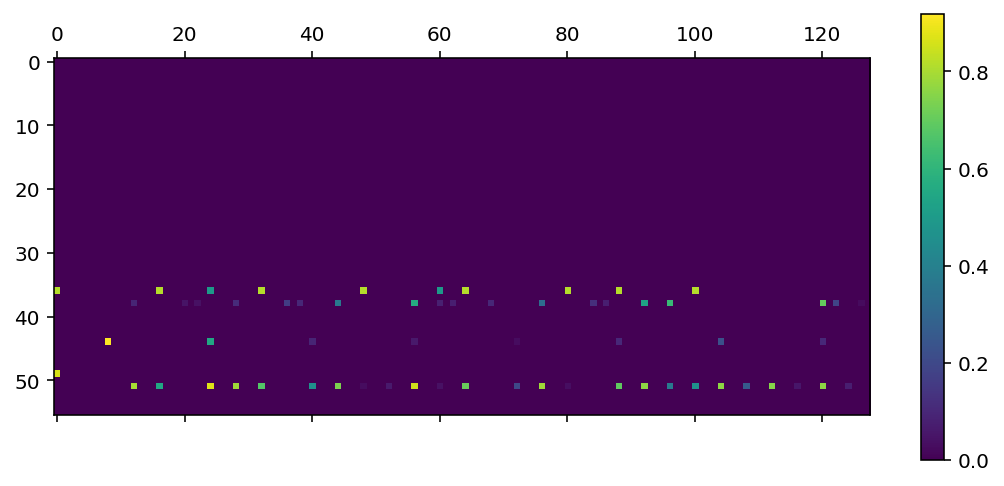

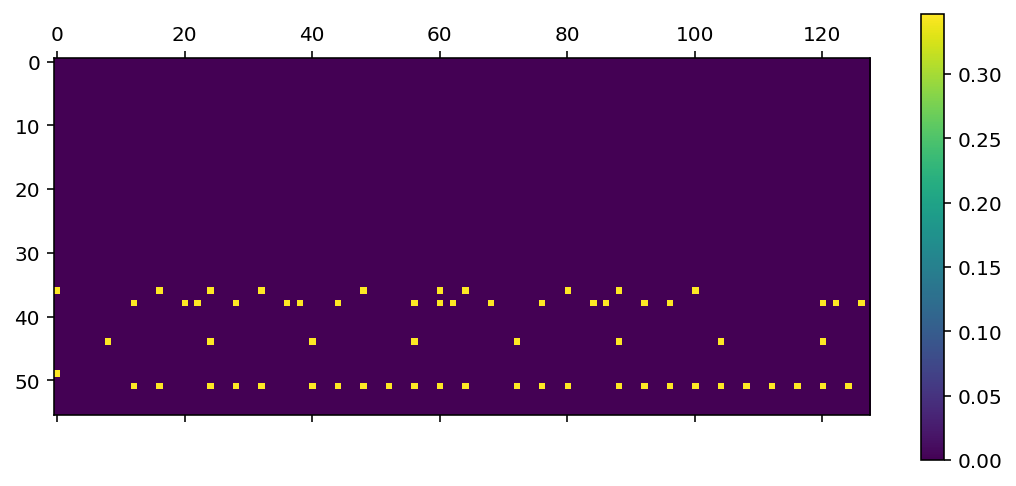

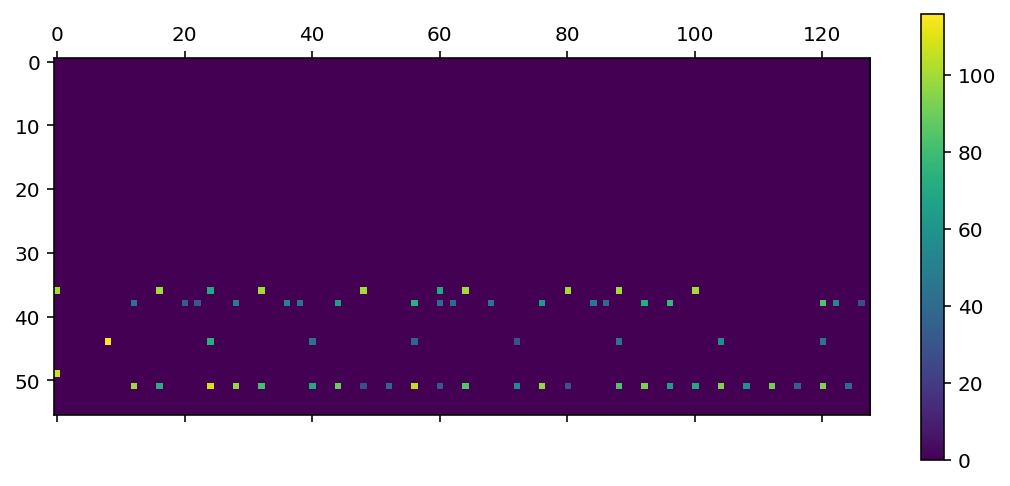

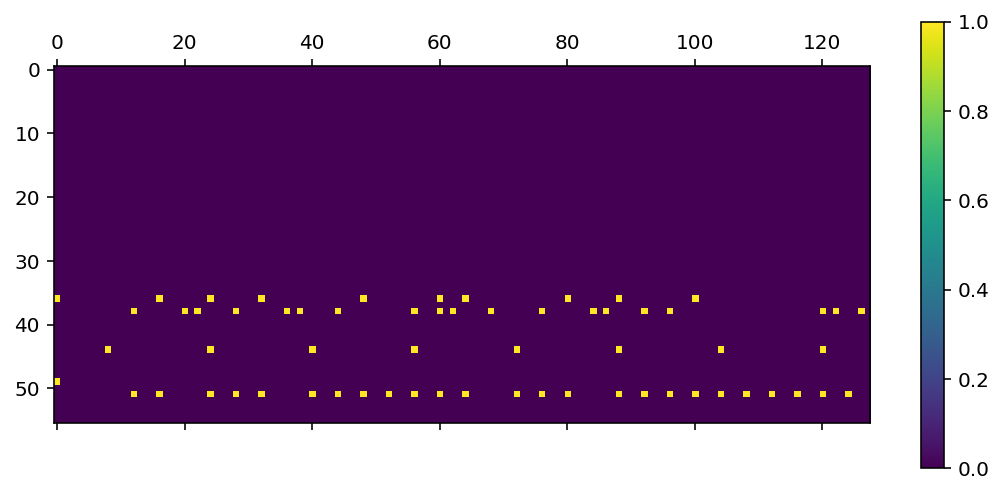

In [ ]:
# print one processed clip 
  # First velocity, second duration
to_print = train_tensor[0]
plt.matshow(to_print[0][:][:])
plt.colorbar()
plt.show()
plt.matshow(to_print[1][:][:])
plt.colorbar()
plt.show()

# TODO: ADD HERE REVERSE TRANSFORMATION FOR THIS ONE CLIP AND PLOT ALL
# Run function under the GENERATE header
to_print_inv = inverse_transform_clip(train_tensor[0])
plt.matshow(to_print_inv[0][:][:])
plt.colorbar()
plt.show()
plt.matshow(to_print_inv[1][:][:])
plt.colorbar()
plt.show()

In [ ]:
# Reference data from the authors 
from_data = np.load("Soul_Rehab_Main_1.npy")
normalized = np.load("Soul_Rehab_Main_1_norm.npy")

to_print1 = normalized.transpose(2,1,0)
plt.matshow(to_print1[0][:][:])
plt.colorbar()
plt.show()
plt.matshow(to_print1[1][:][:])
plt.colorbar()
plt.show()

# TODO: ADD HERE REVERSE TRANSFORMATION FOR THIS ONE CLIP AND PLOT ALL
# Run function under the GENERATE header
to_print_inv1 = from_data.transpose(2,1,0)
plt.matshow(to_print_inv1[0][:][:])
plt.colorbar()
plt.show()
plt.matshow(to_print_inv1[1][:][:])
plt.colorbar()
plt.show()


NameError: ignored

In [ ]:
plot_processed_roll(all_8[0:2][:][:],3)

# DataLoader

In [ ]:
np.save("/content/drive/My Drive/AI/music_wae/train_wae.npy", train_tensor)
np.save("/content/drive/My Drive/AI/music_wae/test_wae.npy", test_tensor)

In [ ]:
train_tensor = np.load("/content/drive/My Drive/AI/music_wae/train.npy")
test_tensor = np.load("/content/drive/My Drive/AI/music_wae/test.npy")

In [ ]:
# The dataloader for the model to use

train_set = torch.Tensor(train_tensor)
print(train_set.size())
train_dataload = torch.utils.data.DataLoader(train_set, batch_size=26)

# Huom muutos !!!! (jos haluut testaa mallin toimivuutta niin aja pelkästään treenisetillä pienellä määrällä)
test_set = torch.Tensor(test_tensor)
print(test_set.size())
test_dataload = torch.utils.data.DataLoader(test_set, batch_size=26)


torch.Size([832, 8, 56, 128])
torch.Size([78, 8, 56, 128])


# The VAE
## Encoder - Decoder structure


In [ ]:
class VAE_Encoder(nn.Module):
  def __init__(self):
    super(VAE_Encoder, self).__init__()
    
    self.conv1 = nn.Conv2d(8, 32, 8, stride=2,padding=3)
    self.b1 = nn.BatchNorm2d(32)
    
    self.conv2 = nn.Conv2d(32, 64, 8, stride=2,padding=3)
    self.b2 = nn.BatchNorm2d(64)

    self.conv3 = nn.Conv2d(64, 128, 8, stride=2,padding=3)
    self.b3 = nn.BatchNorm2d(128)

    self.conv4 = nn.Conv2d(128, 256, 8, stride=2,padding=(4,3)) 
    self.b4 = nn.BatchNorm2d(256)

    self.flat = nn.Flatten(1)

    # For VAE we need two
    self.lin_mu = nn.Linear(8192,3)
    self.lin_logvar = nn.Linear(8192,3)

  def reparameterize(self, mu, logvar):
    """ Reparatemerization trick for the optimization procedure
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
    """
    std = torch.exp(0.5*logvar) # standard deviation
    eps = torch.randn_like(std) # `randn_like` as we need the same size
    sample = mu + (eps * std) # sampling as if coming from the input space (draws from normal distribution)
    return sample

  def forward(self, x):
      x = F.relu(self.b1(self.conv1(x)))
      x = F.relu(self.b2(self.conv2(x)))
      x = F.relu(self.b3(self.conv3(x))) 
      x = F.relu(self.b4(self.conv4(x)))
      x = self.flat(x)
      mu = self.lin_mu(x)
      logvar = self.lin_logvar(x)
      sample = self.reparameterize(mu, logvar)
      return sample, mu, logvar


enc = VAE_Encoder().to(device)
summary(enc, (8, 56, 128))

input_test = torch.rand(1,8,56,128)
print(input_test.shape)
enc = VAE_Encoder()
ret_test = enc.forward(input_test) 
print(ret_test)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 64]          16,416
       BatchNorm2d-2           [-1, 32, 28, 64]              64
            Conv2d-3           [-1, 64, 14, 32]         131,136
       BatchNorm2d-4           [-1, 64, 14, 32]             128
            Conv2d-5           [-1, 128, 7, 16]         524,416
       BatchNorm2d-6           [-1, 128, 7, 16]             256
            Conv2d-7            [-1, 256, 4, 8]       2,097,408
       BatchNorm2d-8            [-1, 256, 4, 8]             512
           Flatten-9                 [-1, 8192]               0
           Linear-10                    [-1, 3]          24,579
           Linear-11                    [-1, 3]          24,579
Total params: 2,819,494
Trainable params: 2,819,494
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.22
Forw

In [ ]:
class VAE_Decoder(nn.Module):
  def __init__(self):
    super(VAE_Decoder, self).__init__()
    
    self.lin1 = nn.Linear(3,28672)

    self.ct1 = nn.ConvTranspose2d(256,128,8,2,3)
    self.b1 = nn.BatchNorm2d(128)
    
    self.ct2 = nn.ConvTranspose2d(128,64,8,2,3)
    self.b2 = nn.BatchNorm2d(64)

    self.ct3 = nn.ConvTranspose2d(64,32,8,2,3)
    self.b3 = nn.BatchNorm2d(32)

    # Padding is added before this layer manually
    self.pad = nn.ZeroPad2d((0, 1, 0, 1))
    self.ct4 = nn.ConvTranspose2d(32,8,8,stride=1,padding=4)
  
  def forward(self, x):
      
      x = F.relu(self.lin1(x).view(-1,256,7,16))
      x = F.relu(self.b1(self.ct1(x)))
      x = F.relu(self.b2(self.ct2(x)))
      x = F.relu(self.b3(self.ct3(x)))

      # Add manual padding f
      x = self.pad(x)
      #x = F.tanh(self.ct4(x))
      x = F.sigmoid(self.ct4(x))

      return x


dec = VAE_Decoder().to(device)
summary(dec,(1,3))

input_test = torch.rand(3)
dec = VAE_Decoder()
ret_test = dec.forward(input_test) 
print(ret_test.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1, 28672]         114,688
   ConvTranspose2d-2          [-1, 128, 14, 32]       2,097,280
       BatchNorm2d-3          [-1, 128, 14, 32]             256
   ConvTranspose2d-4           [-1, 64, 28, 64]         524,352
       BatchNorm2d-5           [-1, 64, 28, 64]             128
   ConvTranspose2d-6          [-1, 32, 56, 128]         131,104
       BatchNorm2d-7          [-1, 32, 56, 128]              64
         ZeroPad2d-8          [-1, 32, 57, 129]               0
   ConvTranspose2d-9           [-1, 8, 56, 128]          16,392
Total params: 2,884,264
Trainable params: 2,884,264
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 8.58
Params size (MB): 11.00
Estimated Total Size (MB): 19.58
-------------------------------------

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## VAE training 



/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Checkpoint saved at 100


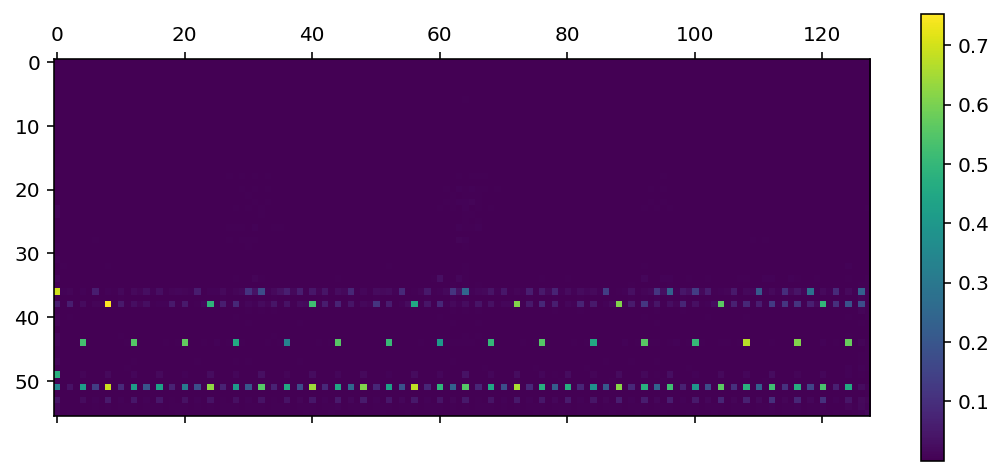

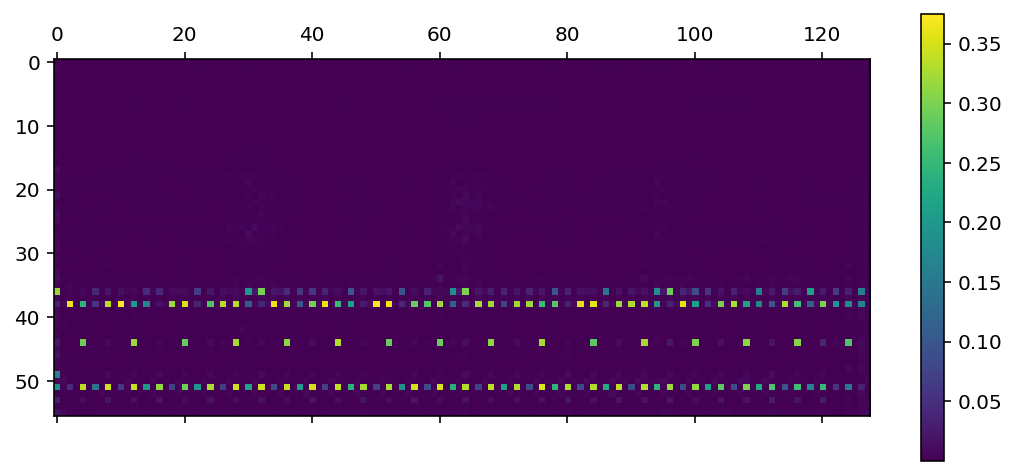

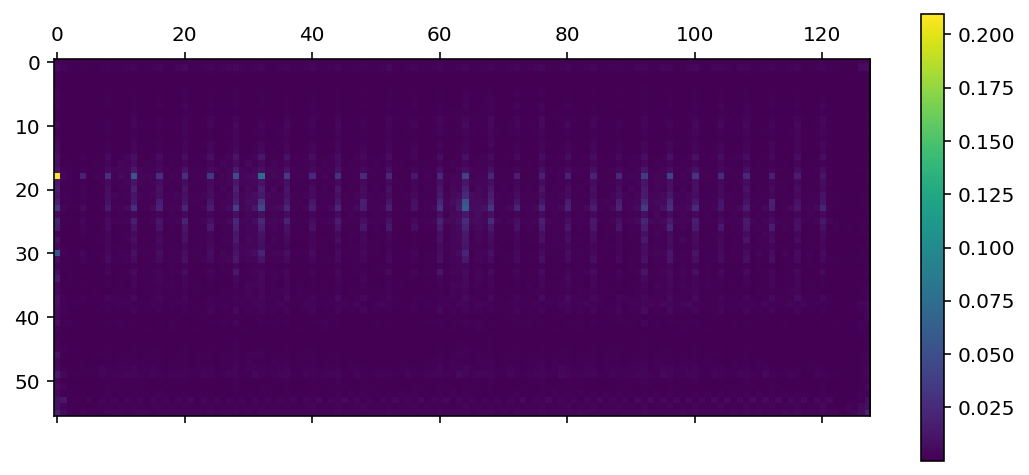

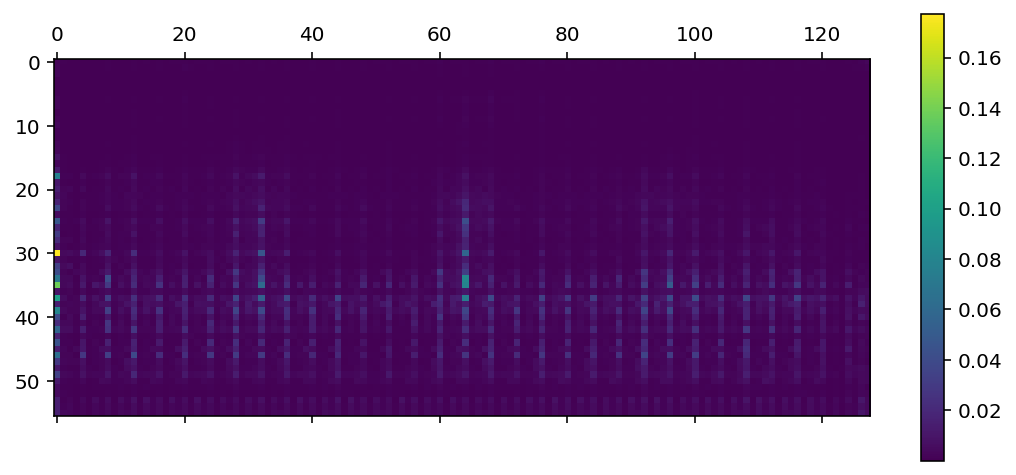

Checkpoint saved at 200


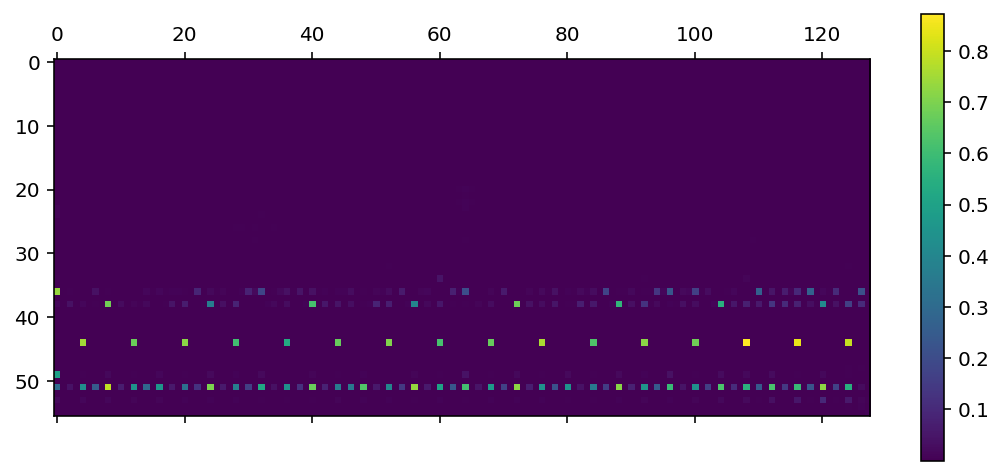

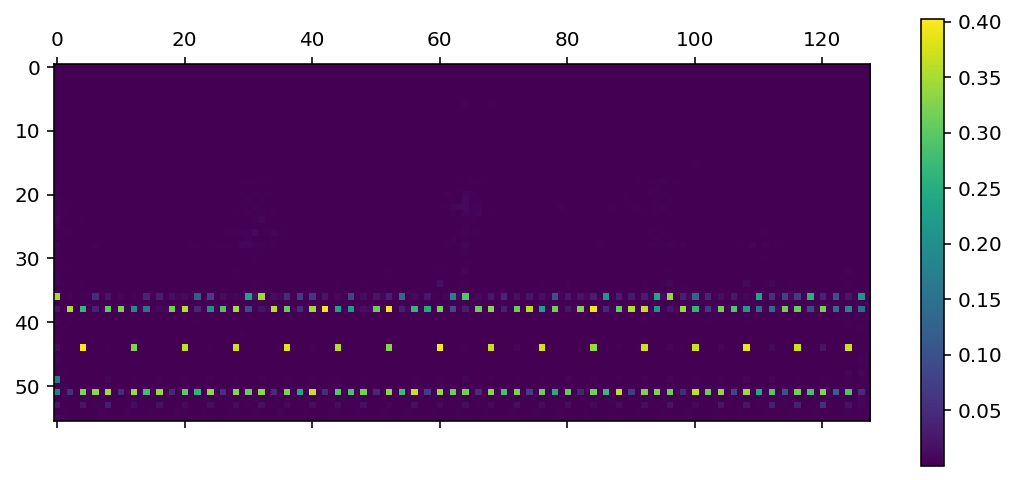

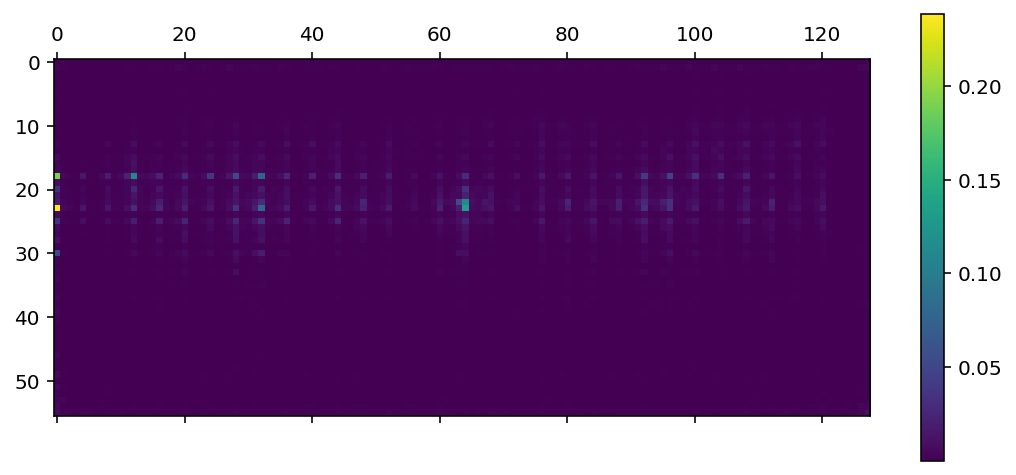

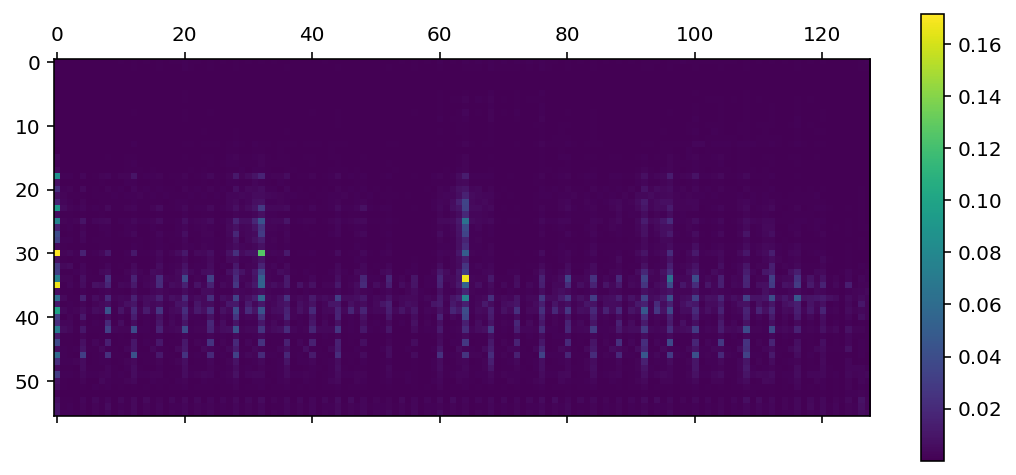

Checkpoint saved at 300


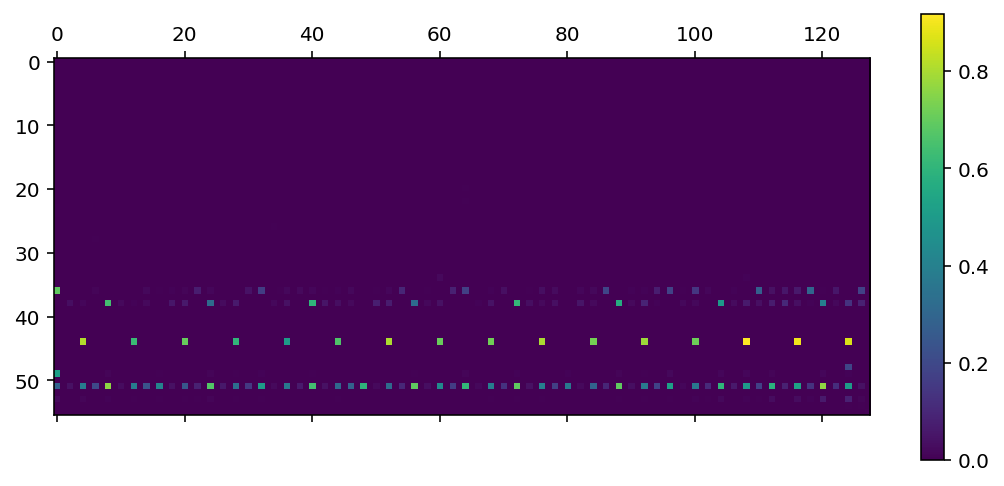

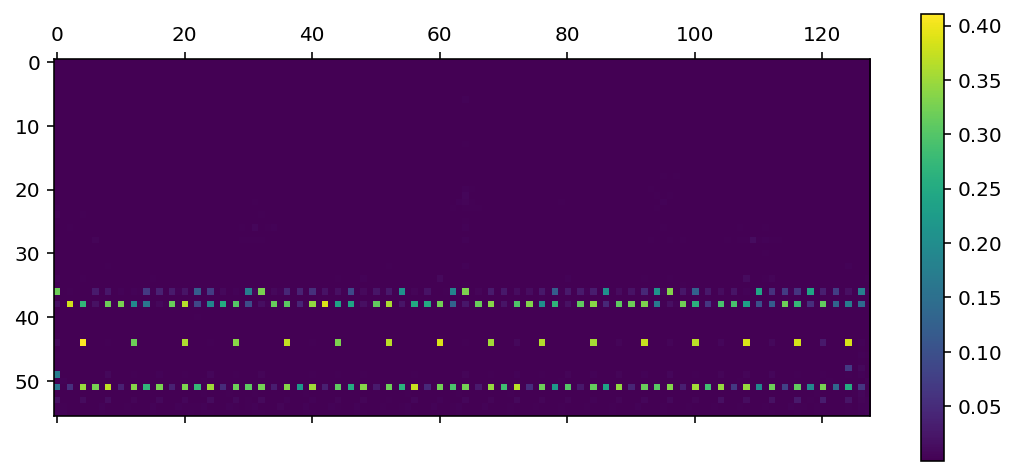

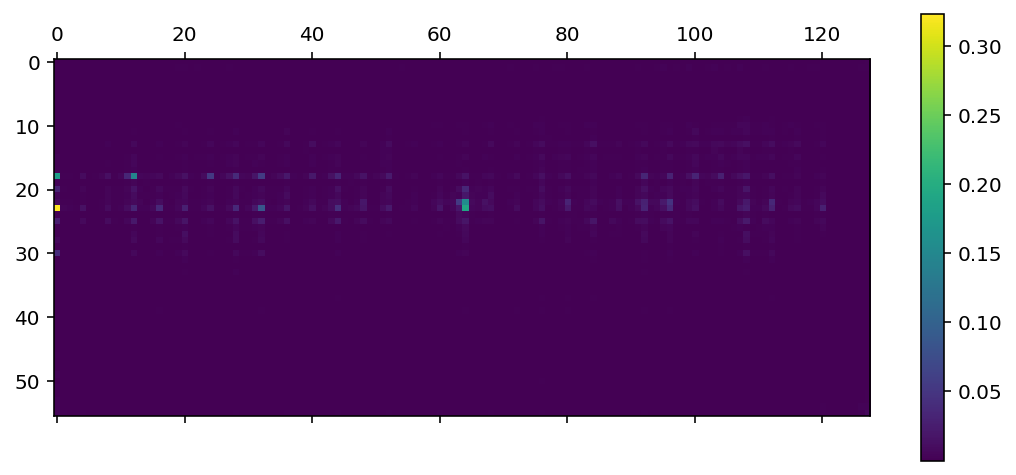

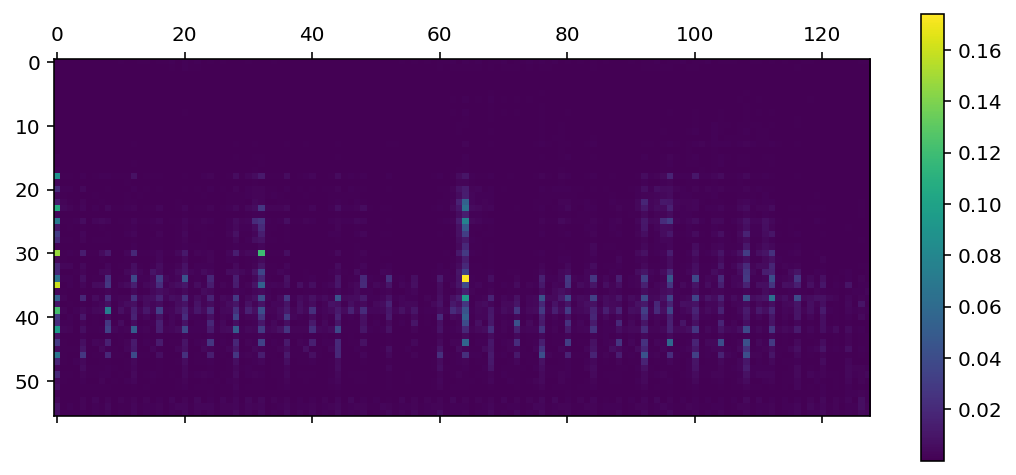

Checkpoint saved at 600


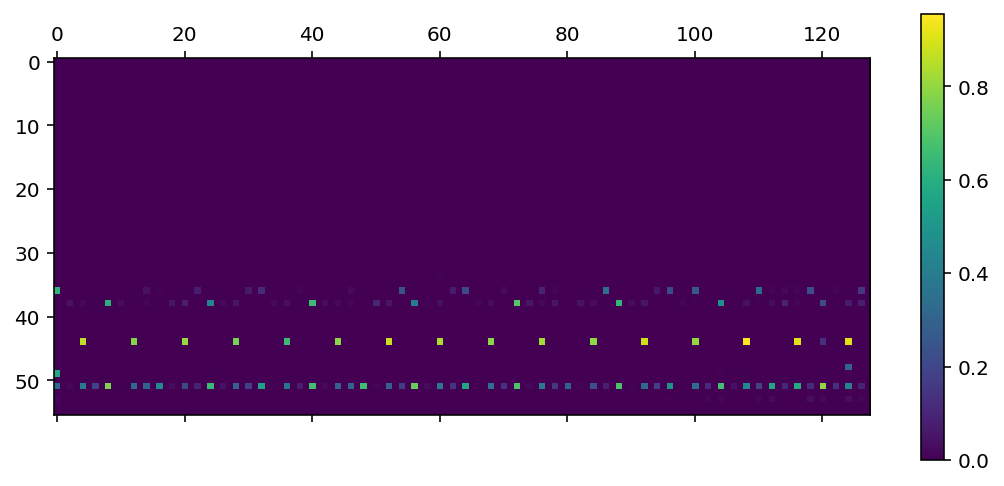

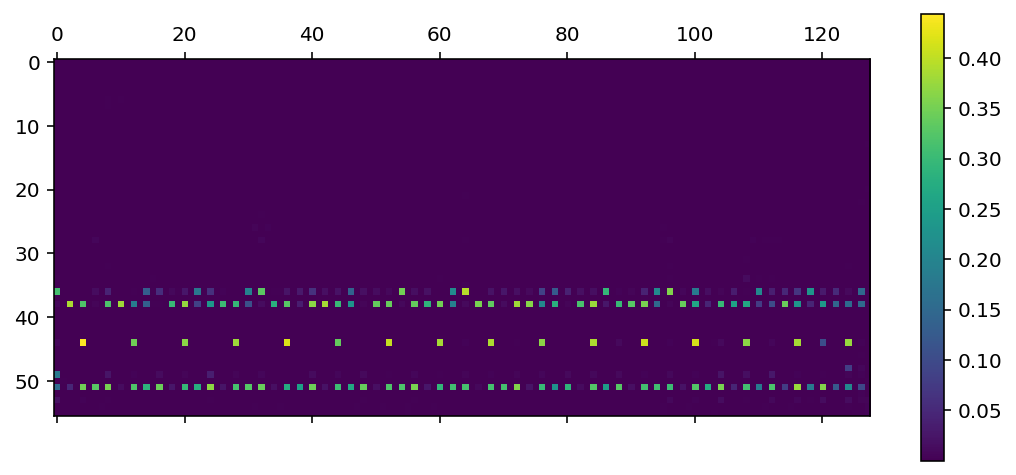

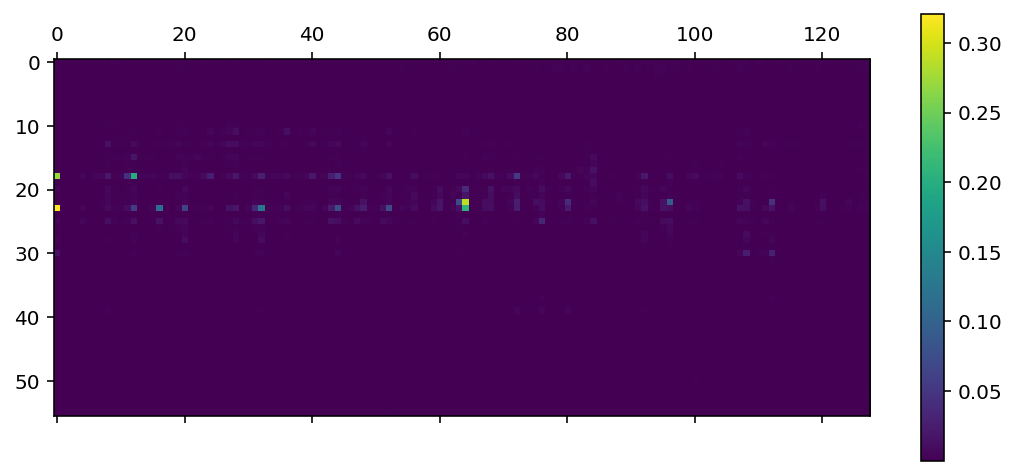

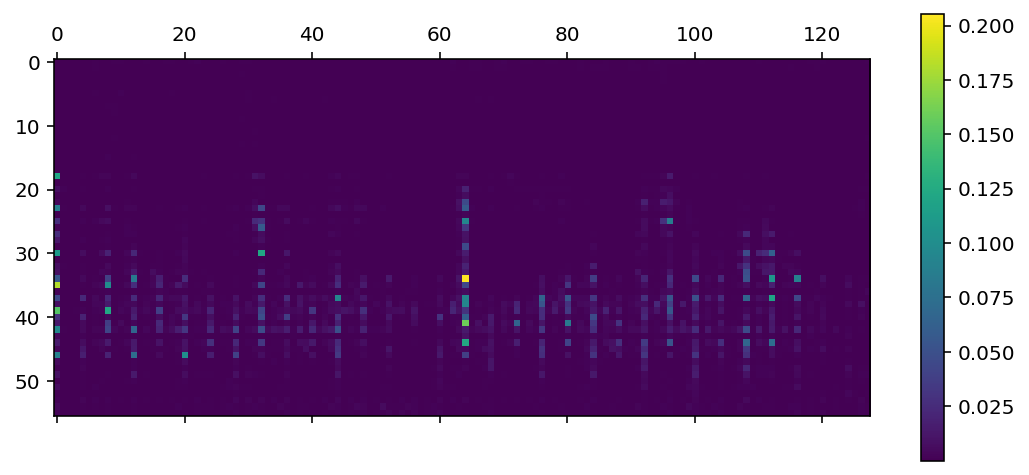

Checkpoint saved at 800


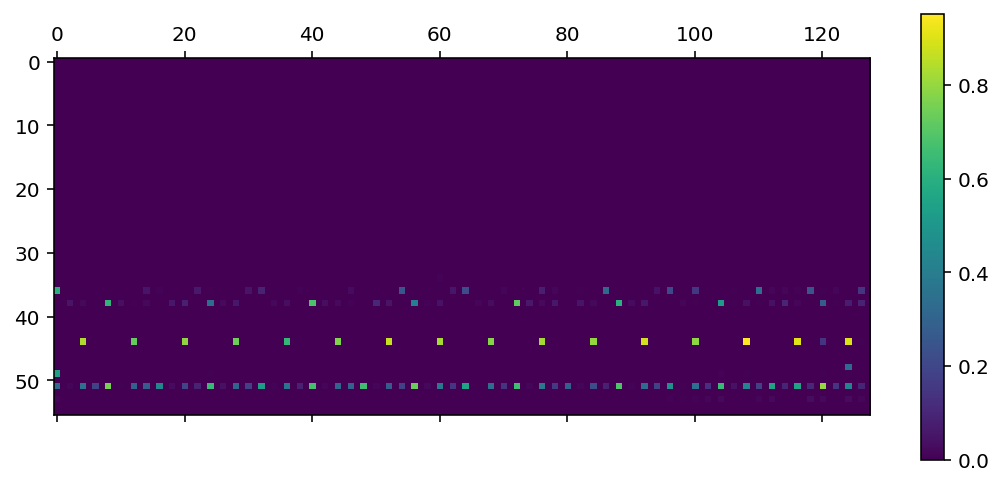

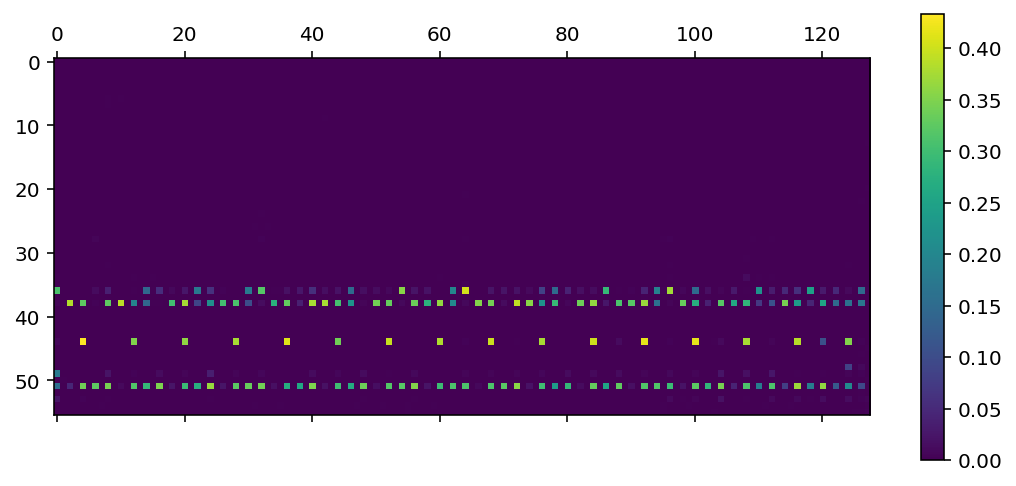

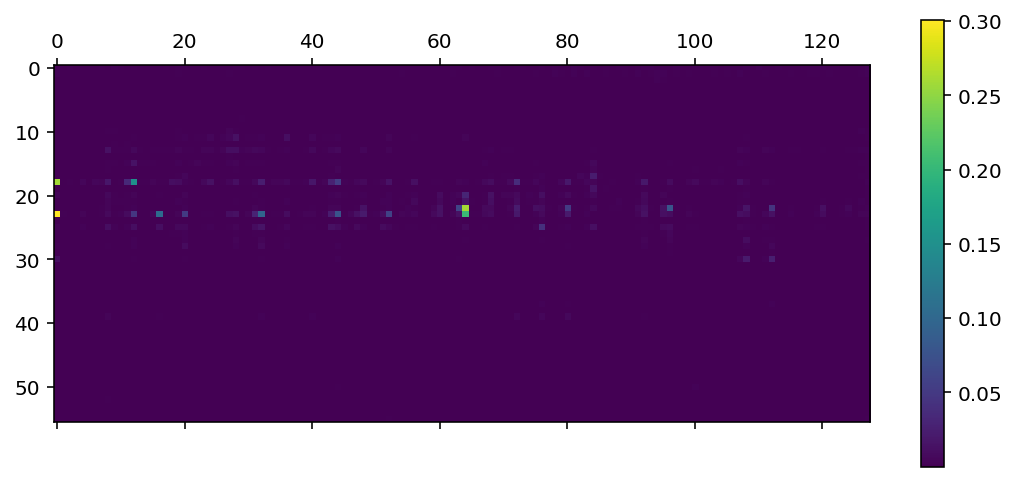

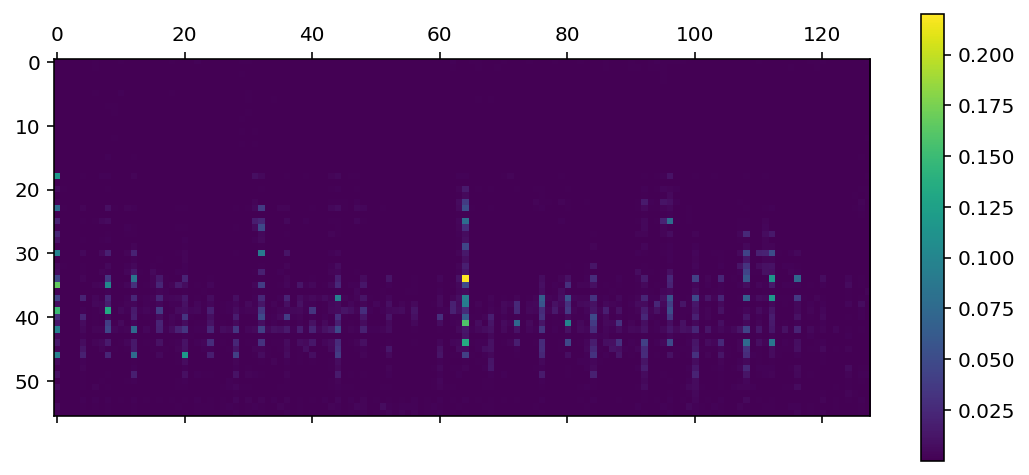

In [ ]:
# Train loop
  # Add loss to list so you can plot it later on

epochs = 1000
batch_size = 10
number_batches = 840/batch_size
number_batches_test = 70/batch_size

ch_points = [100,200,300,600,800,1000] # and 3000 in the end

losses = []
eval_losses = []

lambdaa = 0.1

encoder, decoder = VAE_Encoder().to(device),VAE_Decoder().to(device)
criterion = nn.MSELoss(reduction="sum")
enc_optim = torch.optim.Adam(encoder.parameters(), lr=0.001)
dec_optim = torch.optim.Adam(decoder.parameters(), lr = 0.001)

# Schedulers for the learning rate
enc_scheduler = torch.optim.lr_scheduler.MultiStepLR(enc_optim, milestones=[20,100,500,900], gamma=0.1)
dec_scheduler = torch.optim.lr_scheduler.MultiStepLR(dec_optim, milestones=[20,100,500,900], gamma=0.1)

pbar = tqdm(range(epochs))
for e in pbar:
  running_loss = 0
  running_eval_loss = 0
  running_KL_loss = 0
  enc_scheduler.step()
  dec_scheduler.step()
  
  # Training loop
  for in_data in train_dataload:
      in_data = in_data.to(device)

      # Change the run-setting 
      encoder.train()
      decoder.train()

      # Initialize the gradients 
      encoder.zero_grad()
      decoder.zero_grad()

      # Forward
      z_hat, mu, logvar = encoder(in_data)
      x_hat = decoder(z_hat)

      # Reconstruction loss
      BCE = criterion(x_hat, in_data) / batch_size

      KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size
      ELBO = BCE + lambdaa*KLD

      # Reconstruction error
      running_loss += BCE.item() # get mean
      running_KL_loss += KLD.item() # get mean

      ELBO.backward()

      enc_optim.step()
      dec_optim.step()

  loss = running_loss/number_batches
  losses.append(loss)

  # Save checkpoint at 1000,1500,2000,2500,3000
  if e in ch_points:
    print("Checkpoint saved at", e)
    torch.save({
            'epoch': e,
            'encoder_state_dict': encoder.state_dict() ,
            'decoder_state_dict': decoder.state_dict() ,
            'loss': loss,
            }, "/content/drive/My Drive/AI/music_wae/VAE_final_cp_"+str(e)+".pt")


  # The validation loop
  with torch.no_grad():
    for in_data in test_dataload:
      in_data = in_data.to(device)
      # Change the run-setting 
      encoder.eval()
      decoder.eval()

      # Forward
      z_hat, mu, logvar = encoder(in_data)
      x_hat = decoder(z_hat)

      # Reconstruction loss
      BCE = criterion(x_hat, in_data) / batch_size

      KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size
      ELBO = BCE + lambdaa*KLD

      running_eval_loss += BCE.item()

    if e in ch_points:
        clip_show = np.squeeze(x_hat.cpu().data.numpy())[0]
        
        plt.matshow(clip_show[0][:][:])
        plt.colorbar()
        plt.show()
        plt.matshow(clip_show[1][:][:])
        plt.colorbar()
        plt.show()

        plt.matshow(clip_show[3][:][:])
        plt.colorbar()
        plt.show()
        plt.matshow(clip_show[5][:][:])
        plt.colorbar()
        plt.show()

  eval_loss = running_eval_loss/number_batches_test
  eval_losses.append(eval_loss)

  # Update the progress bar
  pbar.set_description("[Loss: %.2f], [KL:%.3f], [Eval Loss %.2f])" % (loss,running_KL_loss/number_batches,eval_loss))
  pbar.refresh() # to show immediately the update

  

In [ ]:
# Save models
# Save models

e = 1000 # All around for everything 
torch.save({
            'epoch': e,
            'encoder_state_dict': encoder.state_dict() ,
            'decoder_state_dict': decoder.state_dict() ,
            'loss': loss,
            },"/content/drive/My Drive/AI/music_wae/VAE_final_cp_"+str(e)+".pt")

In [ ]:
# Load models
# Load models
encoder_loaded = VAE_Encoder().to(device)
decoder_loaded = VAE_Decoder().to(device)


checkpoint = torch.load("/content/drive/My Drive/AI/music_wae/VAE_final_cp_1000.pt")
encoder_loaded.load_state_dict(checkpoint['encoder_state_dict'])
decoder_loaded.load_state_dict(checkpoint['decoder_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print("Epochs:",epoch)
print("Loss:",loss)


Epochs: 1000
Loss: 54.879812286013646


Text(0.5, 1.0, 'VAE training [B.size: 10, lr: 0.001 (0.5 drop in three steps 20,100,500,900)]')

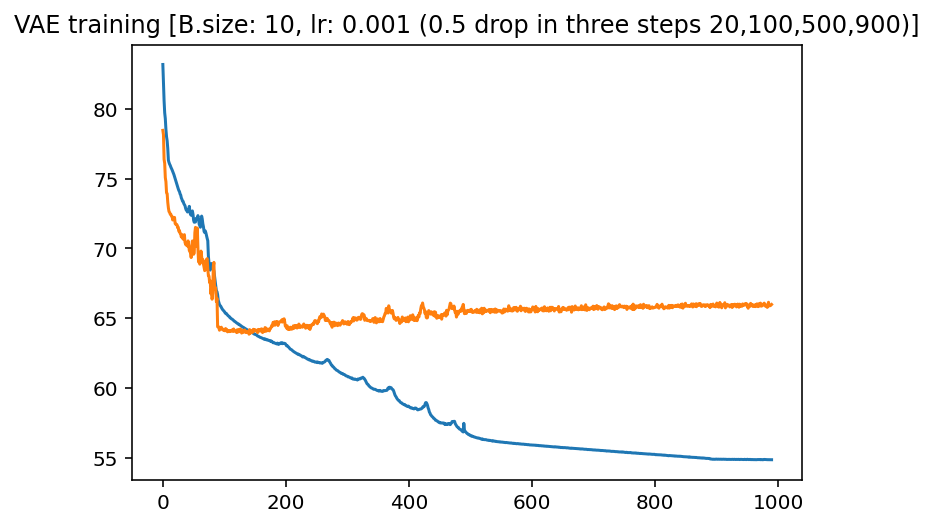

In [ ]:
# Plot loss line-graph
plt.plot(losses[10:])
plt.plot(eval_losses[10:])
plt.title("VAE training [B.size: 10, lr: 0.001 (0.5 drop in three steps 20,100,500,900)]")

# WAE -model


## MMD (Mean maximum descrepancy)
  - gaussian kernel

In [ ]:
class MMD_loss(nn.Module):
  def __init__(self, kernel_mul = 2.0, kernel_num = 5):
    super(MMD_loss, self).__init__()
    self.kernel_num = kernel_num
    self.kernel_mul = kernel_mul
    self.fix_sigma = None
    return
  def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    n_samples = int(source.size()[0])+int(target.size()[0])
    total = torch.cat([source, target], dim=0)
   
    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    L2_distance = ((total0-total1)**2).sum(2) 
    if fix_sigma:
      bandwidth = fix_sigma
    else:
      bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    return sum(kernel_val)

  def forward(self, source, target):
    batch_size = int(source.size()[0])
    kernels = self.guassian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]
    loss = torch.mean(XX + YY - XY -YX)
    return loss

## Encoder - decoder structure (Generator)

In [ ]:
class WAE_Encoder(nn.Module):
  def __init__(self):
    super(WAE_Encoder, self).__init__()
    
    self.conv1 = nn.Conv2d(8, 32, 8, stride=2,padding=3)
    self.b1 = nn.BatchNorm2d(32)
    #self.conv1 = nn.Conv2d(8, 32, 8, stride=2,padding=3)
    #self.b1 = nn.BatchNorm2d(32)
    #self.b1 = nn.LayerNorm([28, 64])
    
    self.conv2 = nn.Conv2d(32, 64, 8, stride=2,padding=3)
    self.b2 = nn.BatchNorm2d(64)
    #self.b2 = nn.LayerNorm([14, 32])

    self.conv3 = nn.Conv2d(64, 128, 8, stride=2,padding=3)
    self.b3 = nn.BatchNorm2d(128)
    #self.b3 = nn.LayerNorm([7, 16])

    self.conv4 = nn.Conv2d(128, 256, 8, stride=2,padding=(4,3)) 
    self.b4 = nn.BatchNorm2d(256)
    #self.b4 = nn.LayerNorm([4, 8])

    self.flat = nn.Flatten(1)

    self.lin_1 = nn.Linear(8192,3)

  def forward(self, x):
      x = F.relu(self.b1(self.conv1(x)))
      x = F.relu(self.b2(self.conv2(x)))
      x = F.relu(self.b3(self.conv3(x))) 
      x = F.relu(self.b4(self.conv4(x)))
      x = self.flat(x)
      x = self.lin_1(x)
      
      return x 

class WAE_Decoder(nn.Module):
  def __init__(self):
    super(WAE_Decoder, self).__init__()
    
    self.lin1 = nn.Linear(3,28672)

    self.ct1 = nn.ConvTranspose2d(256,128,8,2,3)
    self.b1 = nn.BatchNorm2d(128)
    #self.b1 = nn.LayerNorm([14, 32])

    self.ct2 = nn.ConvTranspose2d(128,64,8,2,3)
    self.b2 = nn.BatchNorm2d(64)
    #self.b2 = nn.LayerNorm([28, 64])

    self.ct3 = nn.ConvTranspose2d(64,32,8,2,3)
    self.b3 = nn.BatchNorm2d(32)
    #self.b3 = nn.LayerNorm([56, 128])

    # Padding is added before this layer manually
    self.pad = nn.ZeroPad2d((0, 1, 0, 1))
    self.ct4 = nn.ConvTranspose2d(32,8,8,stride=1,padding=4)


  def forward(self, x):
      
      x = F.relu(self.lin1(x).view(-1,256,7,16))
      x = F.relu(self.b1(self.ct1(x)))
      x = F.relu(self.b2(self.ct2(x)))
      x = F.relu(self.b3(self.ct3(x)))

      # Add manual padding f
      x = self.pad(x)
      #x = F.tanh(self.ct4(x))
      x = F.sigmoid(self.ct4(x))

      return x


dec = WAE_Decoder().to(device)
summary(dec,(1,3))

input_test = torch.rand(3)
dec = WAE_Decoder()
ret_test = dec.forward(input_test) 
print(ret_test.shape)


enc = WAE_Encoder().to(device)
summary(enc, (8, 56, 128))

input_test = torch.rand(1,8,56,128)
print(input_test.shape)
enc = WAE_Encoder()
ret_test = enc.forward(input_test) 
print(ret_test)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1, 28672]         114,688
   ConvTranspose2d-2          [-1, 128, 14, 32]       2,097,280
       BatchNorm2d-3          [-1, 128, 14, 32]             256
   ConvTranspose2d-4           [-1, 64, 28, 64]         524,352
       BatchNorm2d-5           [-1, 64, 28, 64]             128
   ConvTranspose2d-6          [-1, 32, 56, 128]         131,104
       BatchNorm2d-7          [-1, 32, 56, 128]              64
         ZeroPad2d-8          [-1, 32, 57, 129]               0
   ConvTranspose2d-9           [-1, 8, 56, 128]          16,392
Total params: 2,884,264
Trainable params: 2,884,264
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 8.58
Params size (MB): 11.00
Estimated Total Size (MB): 19.58
-------------------------------------

# Train the WAE

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Checkpoint saved at 100


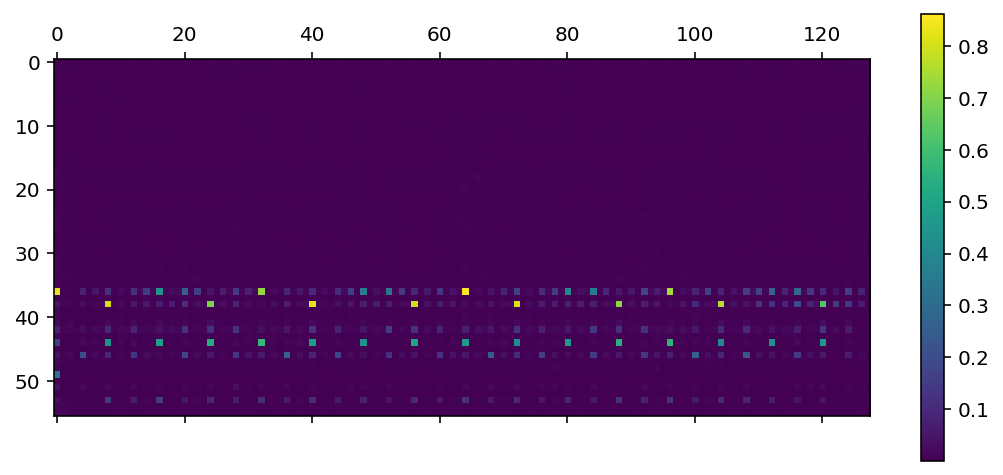

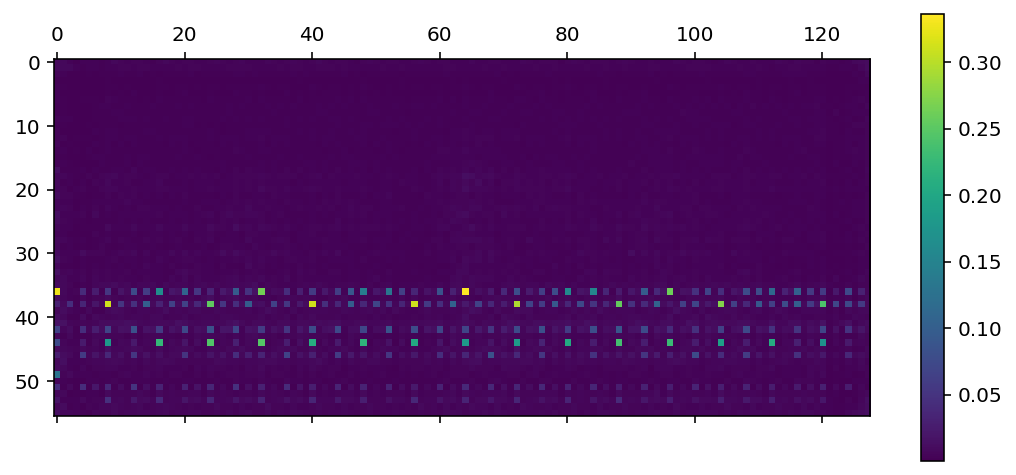

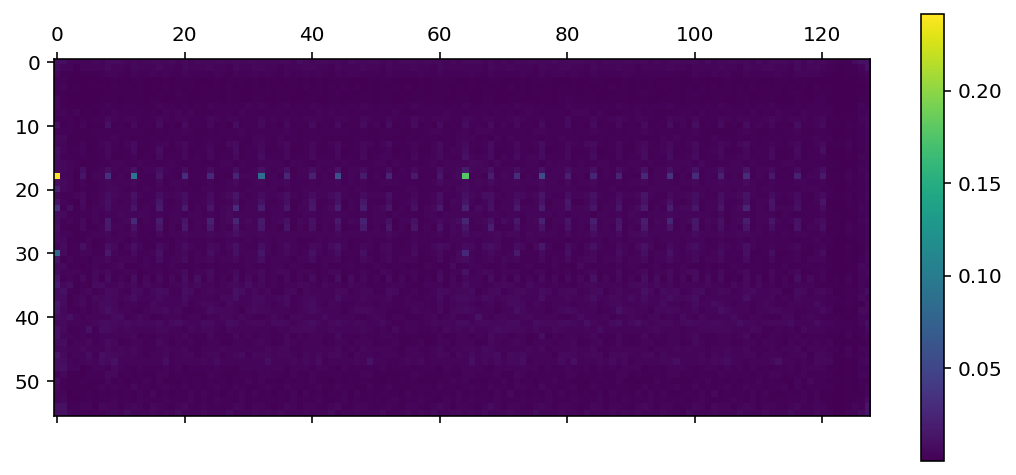

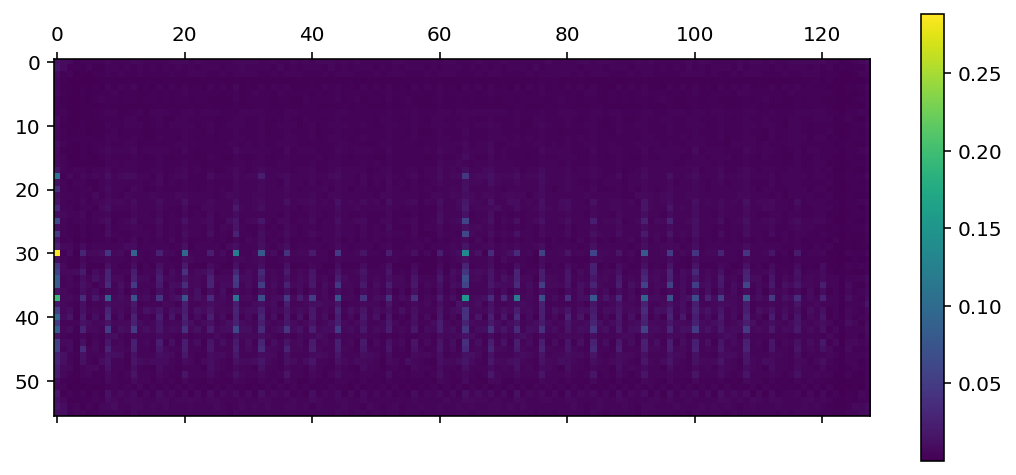

Checkpoint saved at 200


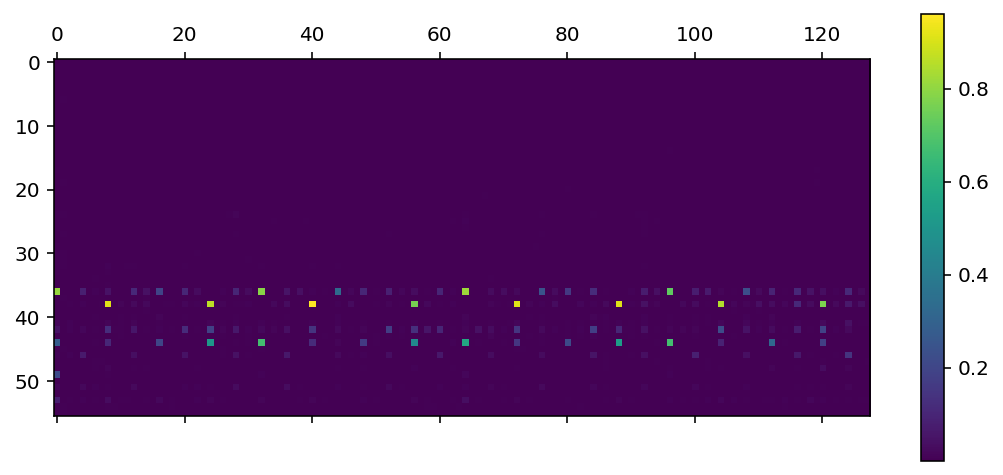

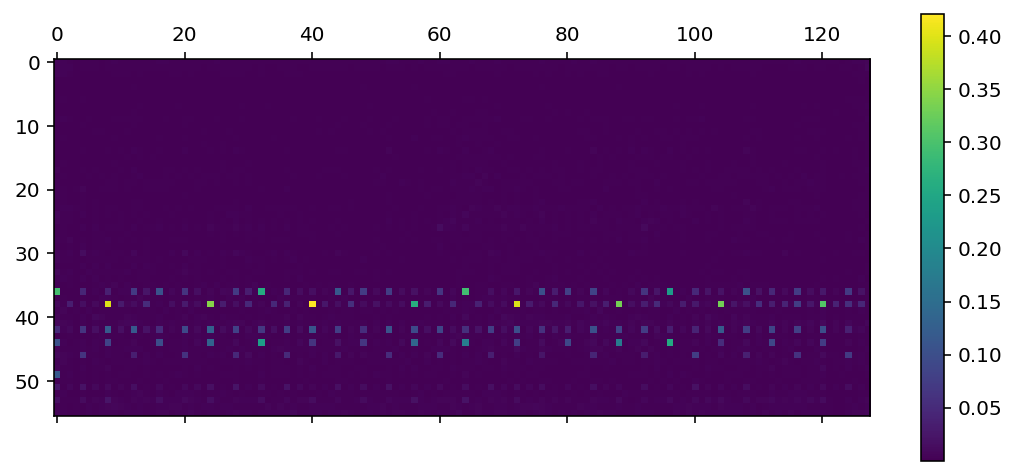

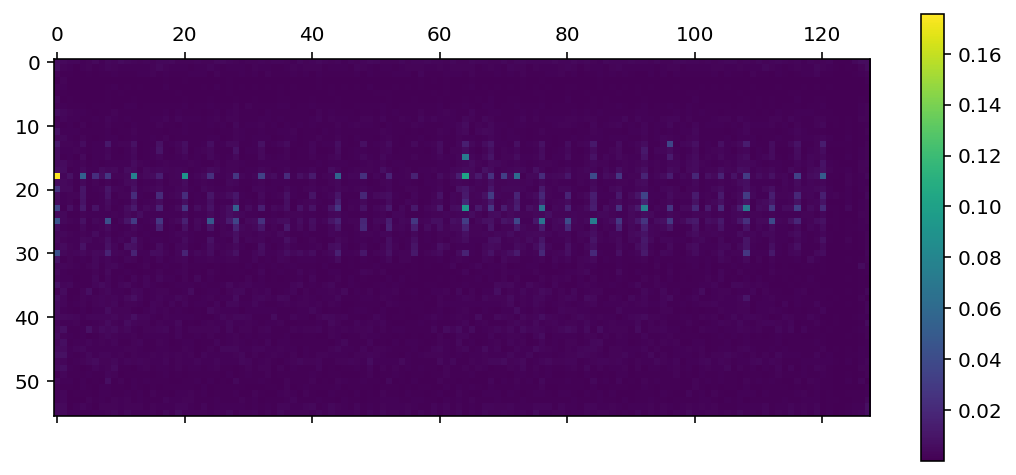

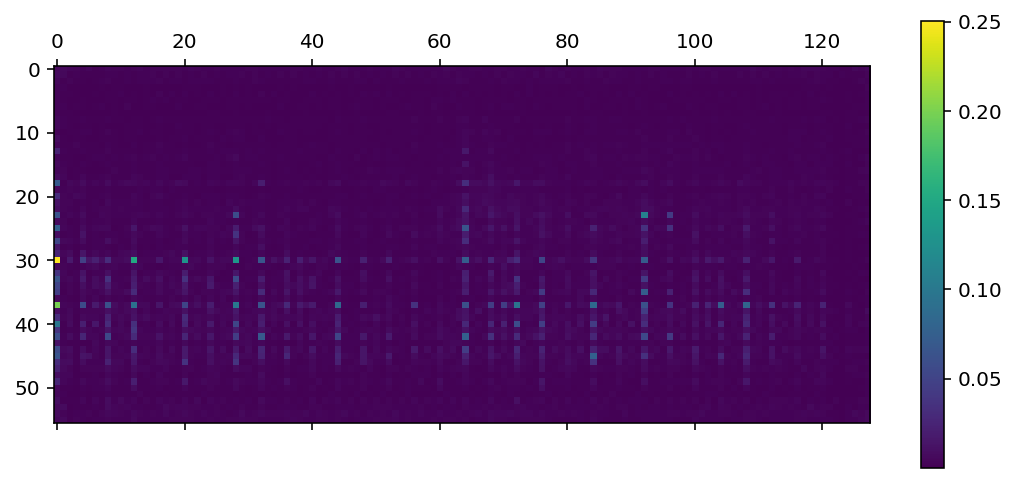

Checkpoint saved at 500


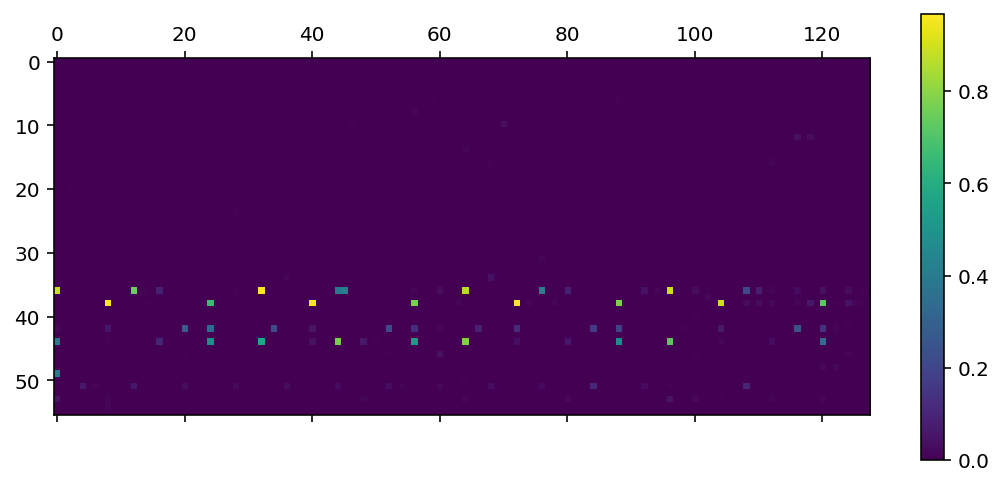

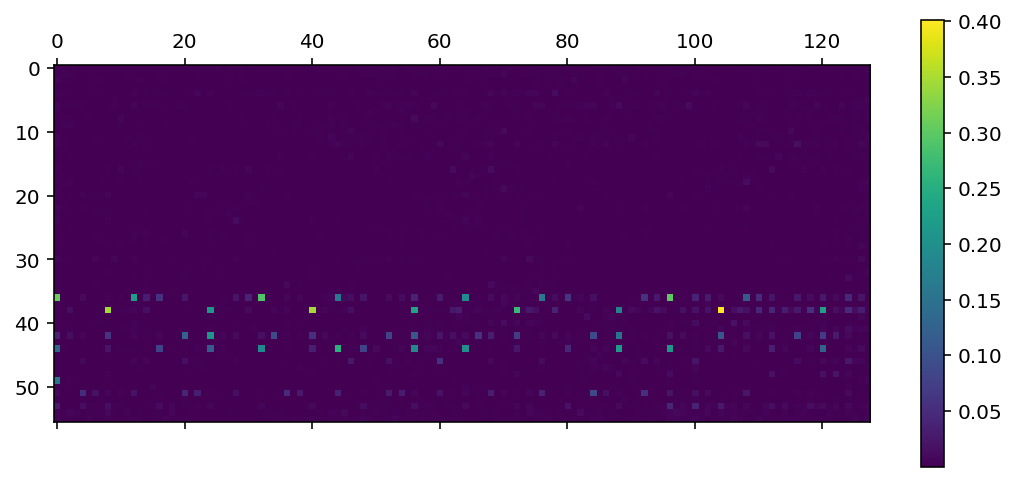

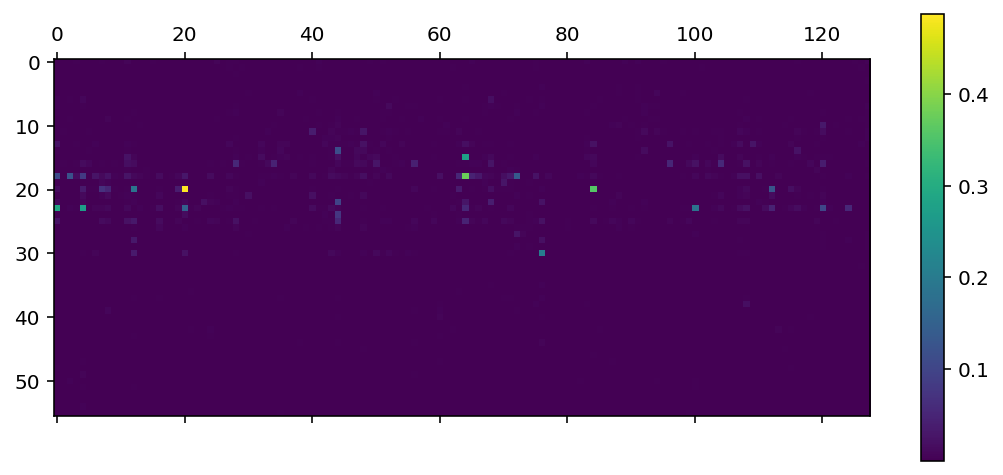

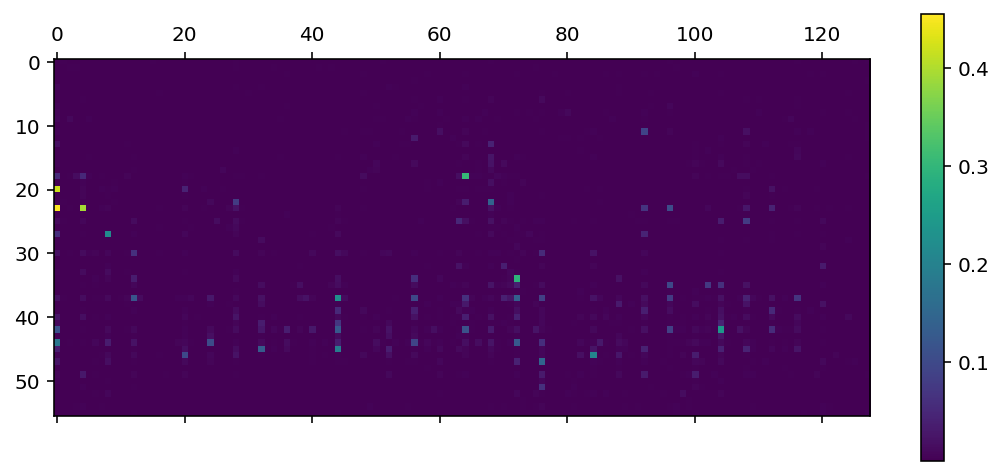

In [ ]:
epochs = 1000 # 3000 about 2h (73 b_size)

# for one instrument
batch_size = 26
number_batches = 832/batch_size
number_batches_test = 78/batch_size
lam = 100

# list of checkpoints
#ch_points = [200,500,1000,3000] # and 3000 in the end
ch_points = [100,200,500,1000,1500,2000,2500,3000] # and 3000 in the end

mmd_l = MMD_loss()

losses = []
mmd_losses = []
eval_losses = []

wae_encoder, wae_decoder = WAE_Encoder().to(device),WAE_Decoder().to(device)

criterion = nn.MSELoss(reduction='sum')

wae_enc_optim = torch.optim.Adam(wae_encoder.parameters(), lr=0.0001)
wae_dec_optim = torch.optim.Adam(wae_decoder.parameters(), lr=0.0001)

# Schedulers for the learning rate
enc_scheduler = torch.optim.lr_scheduler.MultiStepLR(wae_enc_optim, milestones=[100,900,1000,2000], gamma=0.5)
dec_scheduler = torch.optim.lr_scheduler.MultiStepLR(wae_dec_optim, milestones=[100,900,1000,2000], gamma=0.5)
# No scheduler for the discriminator


pbar = tqdm(range(0,epochs))
for e in pbar:
  running_loss = 0
  running_mmd_loss = 0
  running_eval_loss = 0

  enc_scheduler.step()
  dec_scheduler.step()

  # Training loop
  for i, in_data in enumerate(train_dataload):
      in_data = in_data.to(device)


      # ----------------- The reconstruction loss ---------------#
     
      # Initialize the gradients 
      wae_encoder.train()
      wae_decoder.train()

      wae_encoder.zero_grad()
      wae_decoder.zero_grad()
      
      z = wae_encoder(in_data)
      x_recon = wae_decoder(z)

      # Reconstruction loss (mean per minibatch)
      recon_loss = criterion(x_recon, in_data)
      # This used when rediction is sum = averages the loss to batch
      recon_loss = recon_loss / batch_size

      # Reconstruction error
      running_loss = running_loss + recon_loss.detach()



      # ----------------- The MMD loss ---------------------------#
      # Generate random z from N(0,1)
      z_fake = Variable(torch.randn(in_data.size()[0], 3) * 1)
      z_fake = z_fake.to(device)

      z_real = wae_encoder(in_data)

      #mmd_loss = imq_kernel(z, z_fake, 3)
      mmd_loss = mmd_l.forward(z_fake, z_real)
      # Might be unnecessary as class counts the mean
      #mmd_loss = mmd_loss / batch_size 

      running_mmd_loss = running_mmd_loss + mmd_loss

      total_loss = lam * mmd_loss + recon_loss    # PUT WEIGHTS ON LOSSES

      total_loss.backward()

      wae_enc_optim.step()
      wae_dec_optim.step()

  loss = running_loss/number_batches
  losses.append(loss)
  loss_m = running_mmd_loss/number_batches
  mmd_losses.append(loss_m)


  # Save checkpoint at 1000,1500,2000,2500,3000
  if e in ch_points:
    print("Checkpoint saved at", e)
    torch.save({
            'epoch': e,
            'encoder_state_dict': wae_encoder.state_dict() ,
            'decoder_state_dict': wae_decoder.state_dict() ,
            'loss': loss,
            }, "/content/drive/My Drive/AI/music_wae/WAE_final_2_cp_"+str(e)+".pt")

  # The validation loop
  with torch.no_grad():
    for in_data in test_dataload:
      in_data = in_data.to(device)
      # Change the run-setting 
      wae_encoder.eval()
      wae_decoder.eval()

      # Forward
      z = wae_encoder(in_data)
      v_recon = wae_decoder(z)

      # Reconstruction loss (mean per minibatch)
      val_loss = criterion(v_recon, in_data)
      # This used when rediction is sum = averages the loss to batch
      val_loss = val_loss / batch_size

      running_eval_loss = running_eval_loss + val_loss

    if e in ch_points:
      clip_show = np.squeeze(v_recon.cpu().data.numpy())[0]
      
      plt.matshow(clip_show[0][:][:])
      plt.colorbar()
      plt.show()
      plt.matshow(clip_show[1][:][:])
      plt.colorbar()
      plt.show()

      plt.matshow(clip_show[3][:][:])
      plt.colorbar()
      plt.show()
      plt.matshow(clip_show[5][:][:])
      plt.colorbar()
      plt.show()


  eval_loss = running_eval_loss/number_batches_test 
  eval_losses.append(eval_loss)

  # Update the progress bar
  pbar.set_description("[L:%.2f][MMD:%.3f][E%.2f])" % (loss,loss_m,eval_loss))
  #pbar.set_description("[Loss:%.5f][mmd:%.3f][Eval%.5f])" % (loss,loss_m,eval_loss))
  pbar.refresh() # to show immediately the update 

# SAVE LOAD AND PLOT 

In [ ]:
# Save models
#torch.save(wae_encoder.state_dict(), "/content/drive/My Drive/AI/music_wae/WAE_enc_model_12st_500_l1_batchN.pt")
#torch.save(wae_decoder.state_dict(), "/content/drive/My Drive/AI/music_wae/WAE_dec_model_12st_500_l1_batchN.pt")
e = 1000  
torch.save({
            'epoch': e,
            'encoder_state_dict': wae_encoder.state_dict() ,
            'decoder_state_dict': wae_decoder.state_dict() ,
            'loss': loss,
            },"/content/drive/My Drive/AI/music_wae/WAE_final_2_cp_"+str(e)+".pt")

In [ ]:
# Load models
wae_encoder_loaded = WAE_Encoder().to(device)
wae_decoder_loaded = WAE_Decoder().to(device)
#wae_encoder_loaded.load_state_dict(torch.load("/content/drive/My Drive/AI/music_wae/WAE_enc_model_testWithShed.pt"))
#wae_decoder_loaded.load_state_dict(torch.load("/content/drive/My Drive/AI/music_wae/WAE_dec_model_testWithShed.pt"))

#wae_encoder_loaded.load_state_dict(torch.load("/content/drive/My Drive/AI/music_wae/WAE_enc_model_severely_overfitted.pt"))
#wae_decoder_loaded.load_state_dict(torch.load("/content/drive/My Drive/AI/music_wae/WAE_dec_model_severely_overfitted.pt"))

#wae_encoder_loaded.load_state_dict(torch.load("/content/drive/My Drive/AI/music_wae/WAE_enc_model_10st_3k_l500.pt"))
#wae_decoder_loaded.load_state_dict(torch.load("/content/drive/My Drive/AI/music_wae/WAE_dec_model_10st_3k_l500.pt"))

checkpoint = torch.load("/content/drive/My Drive/AI/music_wae/WAE_final_2_cp_1000.pt")
wae_encoder_loaded.load_state_dict(checkpoint['encoder_state_dict'])
wae_decoder_loaded.load_state_dict(checkpoint['decoder_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print("Epochs:",epoch)
print("Loss:",loss)


Epochs: 1000
Loss: tensor(31.1779, device='cuda:0')


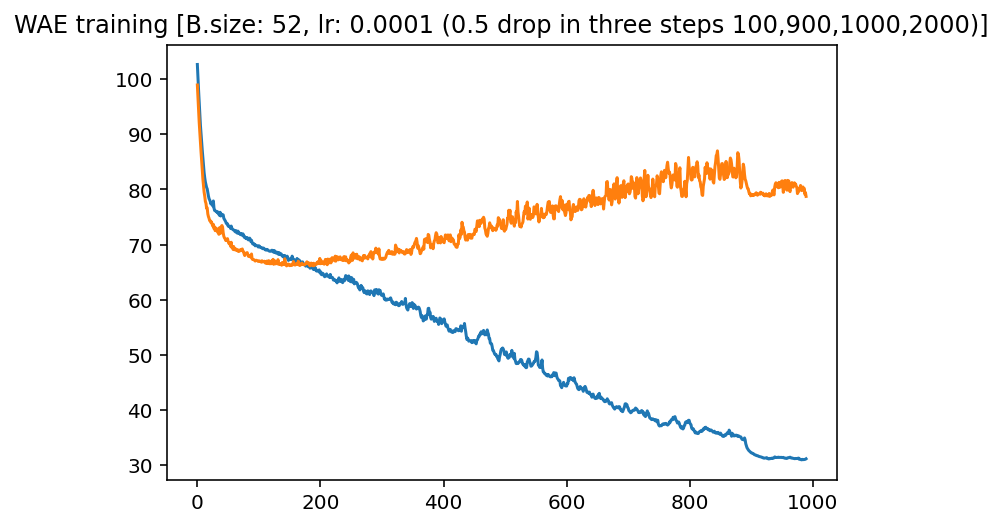

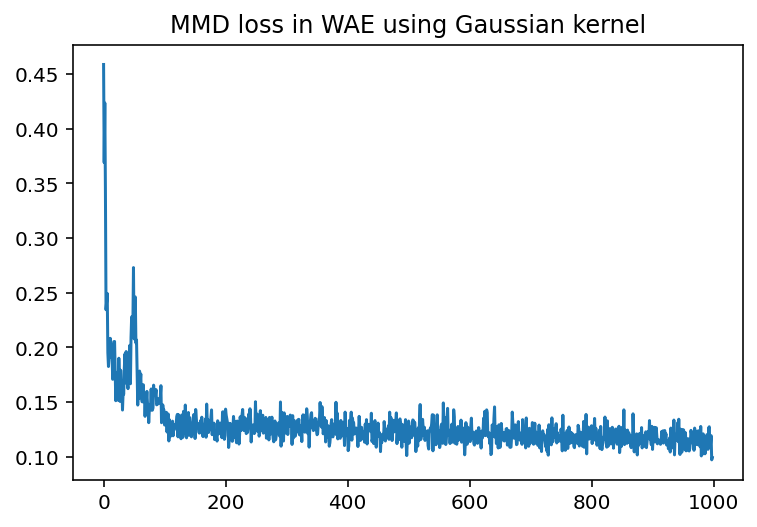

In [ ]:
# Plot loss line-graph
plt.plot(losses[10:])
plt.plot(eval_losses[10:])
#plt.yscale("log")
#plt.title("[2500e] Running loss with batch size 73 and learning rate 0.0001 (0.5 every 1000)")
plt.title("WAE training [B.size: 52, lr: 0.0001 (0.5 drop in three steps 100,900,1000,2000)]")
plt.show()
plt.plot(mmd_losses[1:])
plt.title("MMD loss in WAE using Gaussian kernel")
plt.show()

# Generate

In [ ]:
# Function to reverse transform the datapoints

def inverse_transform_clip(clip, tr_v=qt_v, tr_d=qt_d):
  """
  clip = [8,128,55] numpy array (output of the decoder)
  tr_v = velocity trained quantile transformer
  tr_d = duration trained quantile transformer 
  """
  transformed_clip = np.zeros(clip.shape)

  # Loop instruments 
  for i in range(0,8):
    if i%2 == 0:
      # use velocity transformer
      tr_to_use = tr_v
    else:
      # use duration transformer
      tr_to_use = tr_d
    
    # Flatten and then reverse transform
    channel = clip[i][:][:]
    wanted_shape = channel.shape
    flat_channel = channel.flatten()
    flat_channel = np.expand_dims(np.array(flat_channel),1)
    flat_revtr_channel = np.round(tr_to_use.inverse_transform(flat_channel))
    # reshape back to original form
    revtr_channel = np.reshape(flat_revtr_channel, wanted_shape)

    transformed_clip[i][:][:] = revtr_channel

  return transformed_clip   




In [ ]:
import statistics

# Count the reconstruction error on the test set
L1 = []
L2 = []
batch_size = 26

for d in test_dataload:
    in_d = d.to(device)
    z = wae_encoder_loaded(in_d)
    clip = wae_decoder_loaded(z)
    #z,m,l = encoder_loaded(in_d)
    #clip = decoder_loaded(z)
    # Reconstruction
    L2.append(F.mse_loss(in_d,clip, reduction='sum').item()/batch_size)
    L1.append(F.l1_loss(in_d,clip,  reduction='sum').item()/batch_size)

print("MEAN L1 RECONSTRUCTION ERROR ON TRAIN SET: ", statistics.mean(L1))
print("MEAN L2 RECONSTRUCTION ERROR ON TRAIN SET: ", statistics.mean(L2))

  

MEAN L1 RECONSTRUCTION ERROR ON TRAIN SET:  161.50226612580127
MEAN L2 RECONSTRUCTION ERROR ON TRAIN SET:  83.11097443409456


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


VAE:
* MEAN L1 RECONSTRUCTION ERROR ON TEST SET:  168.23731515066964
* MEAN L2 RECONSTRUCTION ERROR ON TEST SET:  67.06531808035714
* MEAN L1 RECONSTRUCTION ERROR ON TRAIN SET:  154.05455336797806
* MEAN L2 RECONSTRUCTION ERROR ON TRAIN SET:  54.88353449503581

WAE:
* MEAN L1 RECONSTRUCTION ERROR ON TRAIN SET:  76.39315
* MEAN L2 RECONSTRUCTION ERROR ON TRAIN SET:  31.392998
* MEAN L1 RECONSTRUCTION ERROR ON TEST SET:  161.602267
* MEAN L2 RECONSTRUCTION ERROR ON TEST SET:  83.11097



1. the network input, 2. The decoder output


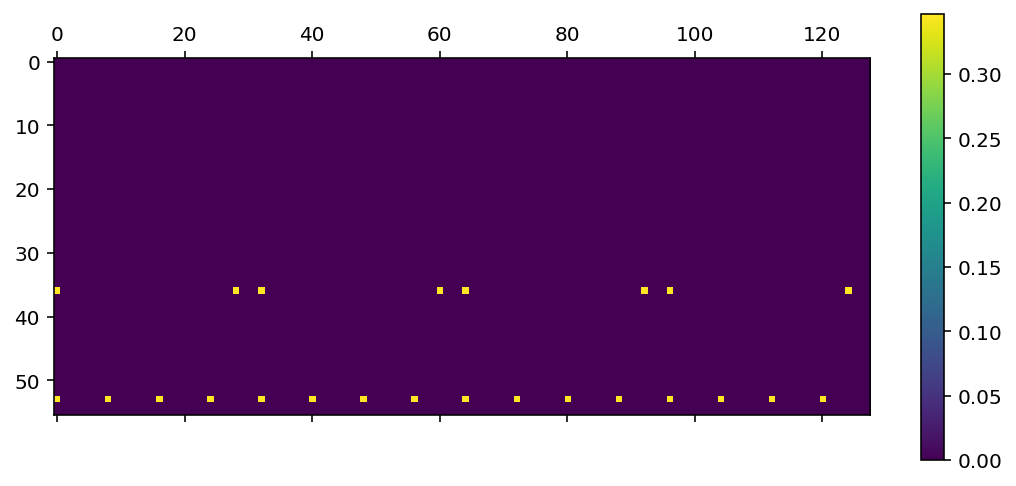

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Using a target size (torch.Size([1, 8, 56, 128])) that is different to the input size (torch.Size([8, 56, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 8, 56, 128])) that is different to the input size (torch.Size([8, 56, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


L2- reconstruction loss:  tensor(66.2613, device='cuda:0', grad_fn=<MseLossBackward>)
L1- reconstruction loss:  tensor(127.0225, device='cuda:0', grad_fn=<L1LossBackward>)


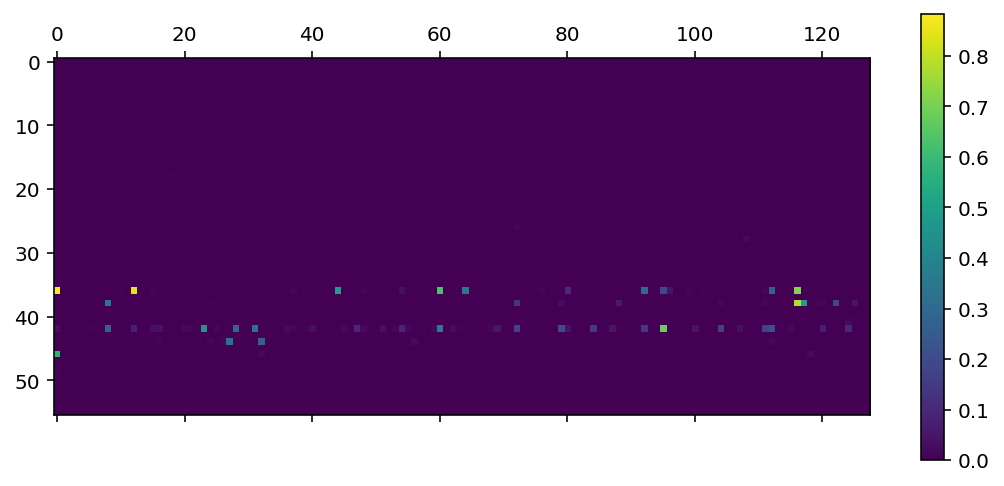

3. The inverse transformed clip


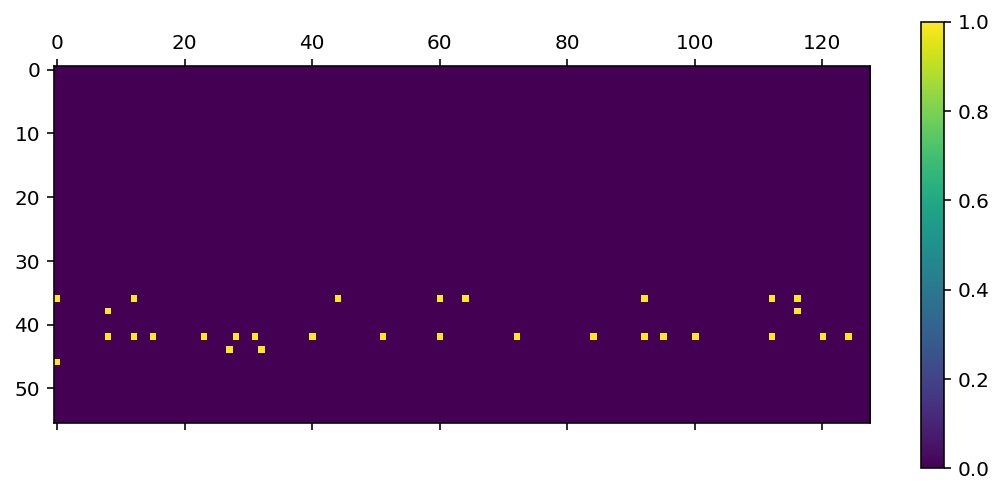

In [ ]:
reconstruction_test = True
# Generate new sample 

def generate_music(decoder,latent=torch.empty(3).normal_(mean=0,std=1).to(device)):
  # Input to the decoder
  clip = decoder(latent)

  # Apply post processing to the notes based on the study
  clip_np = np.squeeze(clip.cpu().data.numpy())

  de_clip_np = clip_np

  return de_clip_np, clip 


print("1. the network input, 2. The decoder output")
# Plot the train sample before network

if reconstruction_test:
  # Try to reconstruct one sample from train or test set
  for d in train_dataload:
    in_d = d.to(device)
    z = wae_encoder_loaded(in_d)
    #z,m,l = encoder_loaded(in_d)
    break

  clip_in = np.squeeze(in_d.cpu().data.numpy())
  plt.matshow(clip_in[0][1][:][:])
  plt.colorbar()
  plt.show()

  clip_ret, clip_gen = generate_music(wae_decoder_loaded, z[0])
  #clip_ret, clip_gen = generate_music(decoder_loaded, z[0])

  #print(clip_ret.shape)

  # Reconstruction
  print("L2- reconstruction loss: ", F.mse_loss(in_d[0],clip_gen, reduction='sum') )
  print("L1- reconstruction loss: ", F.l1_loss(in_d[0],clip_gen,  reduction='sum') )

else:
  clip_ret, clip = generate_music(wae_decoder_loaded)
  #print(clip_ret.shape)

 # Plot decoder output 
plt.matshow(clip_ret[0][:][:])
plt.colorbar()
plt.show()


inv_tr_clip = inverse_transform_clip(clip_ret)
print("3. The inverse transformed clip")
plt.matshow(inv_tr_clip[1][:][:])
plt.colorbar()
plt.show()

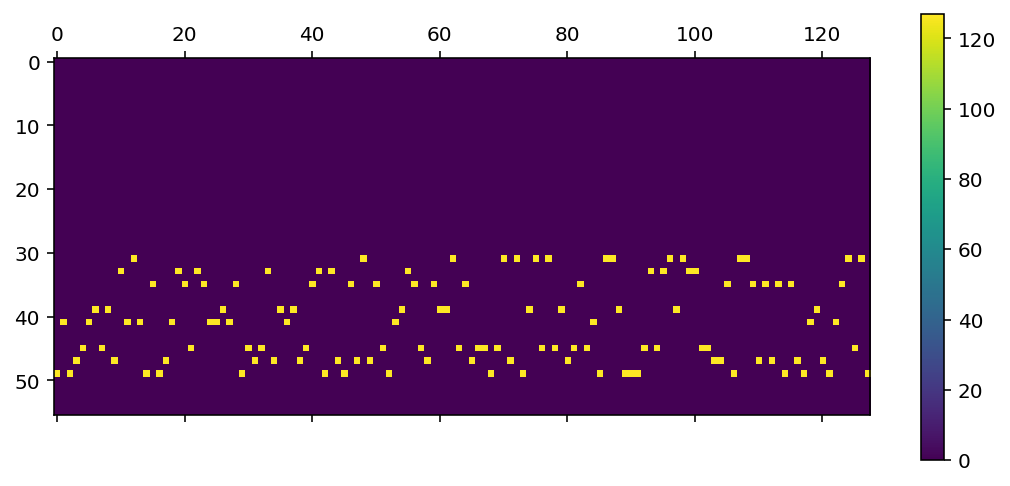

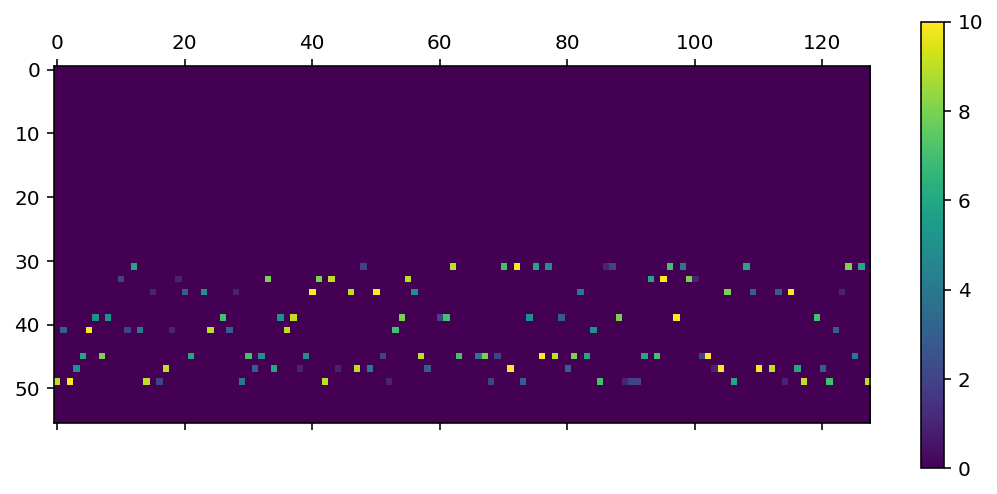

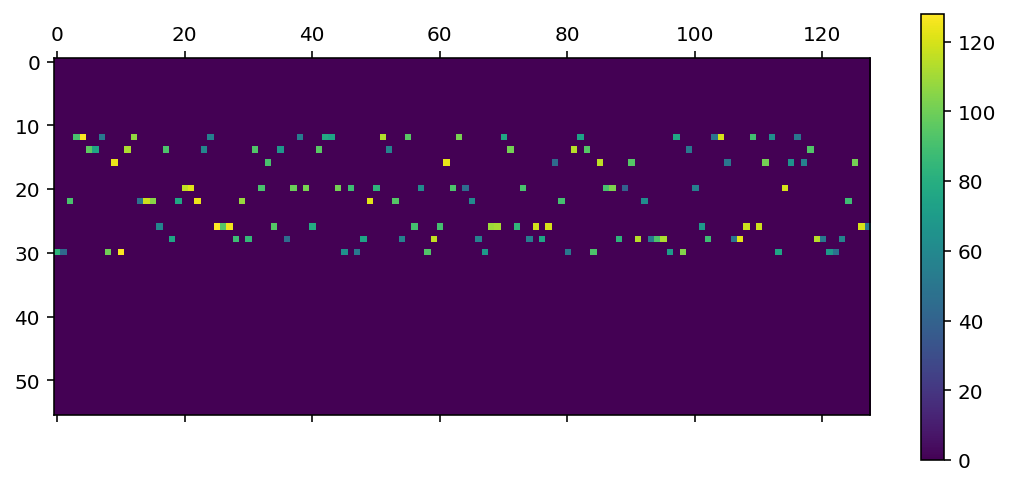

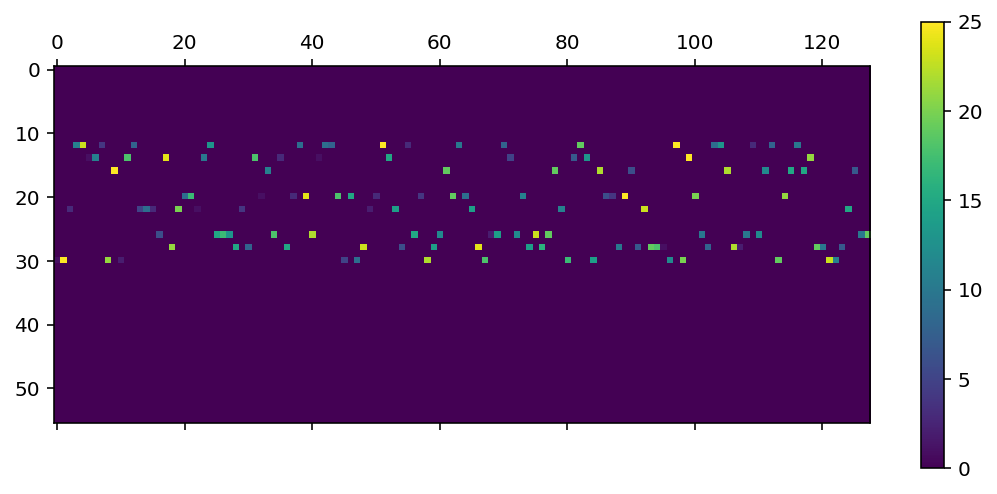

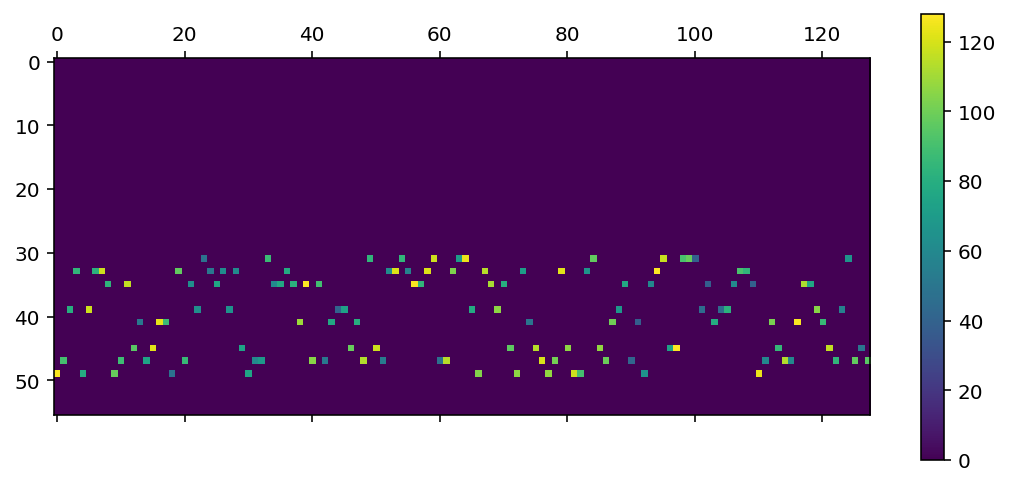

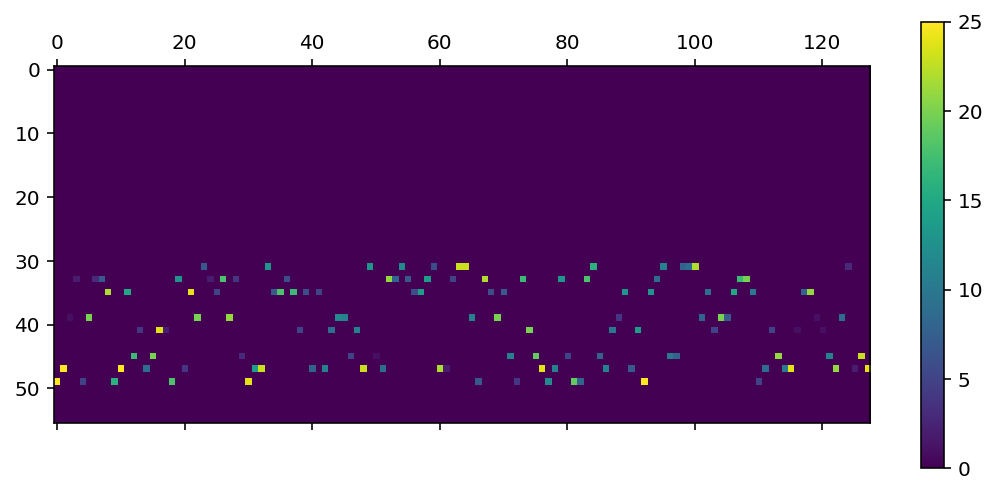

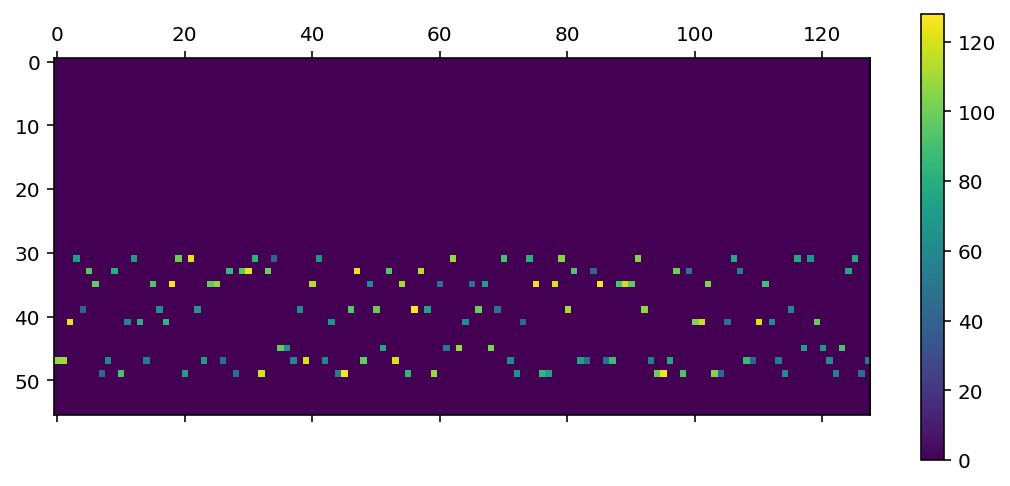

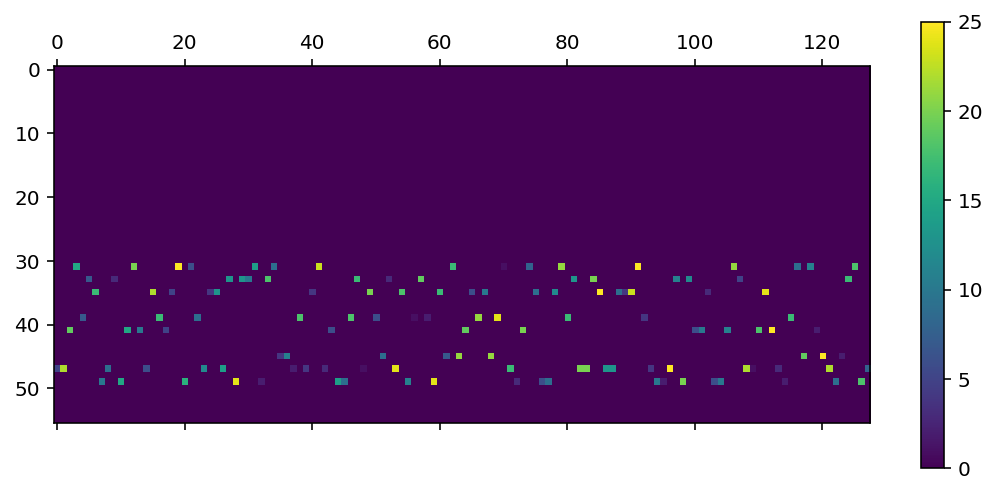

In [ ]:
#clip_show = inv_tr_clip
clip_show = np.array(tensor_base[0])
#clip_show = clip_in[0][:][:][:]
plt.matshow(clip_show[0][:][:])
plt.colorbar()
plt.show()
plt.matshow(clip_show[1][:][:])
plt.colorbar()
plt.show()

plt.matshow(clip_show[2][:][:])
plt.colorbar()
plt.show()
plt.matshow(clip_show[3][:][:])
plt.colorbar()
plt.show()

plt.matshow(clip_show[4][:][:])
plt.colorbar()
plt.show()
plt.matshow(clip_show[5][:][:])
plt.colorbar()
plt.show()

plt.matshow(clip_show[6][:][:])
plt.colorbar()
plt.show()
plt.matshow(clip_show[7][:][:])
plt.colorbar()
plt.show()

In [ ]:
# The gamma correction function

def gamma_correction(v, g):
  """
  v = float velocity value
  g = float gamma value
  """
  ret = math.floor(127 * pow((v/127),(1/g)))

  return ret


In [ ]:
# Loop through the events and apply the velocity gamma correction
# drums = 16, bass=39, rhodes= 4, hammond=17

def post_process(clip_ret, time):

  # Do the inverse transform
  clip_ret = inverse_transform_clip(clip_ret)

  instruments=["Drum track", "Bass track", "Rhodes track", "Hammond track"]
  programs=[16,39,4,17]
  gamma_v = [2.9,3.5,4.0,3.5]

  # Delete notes that are below 1
  clip_ret[clip_ret < 1] = 0.0 

  whole_clip = []
  muspy_obj = muspy.Music(resolution=480) # Might need to be added something more

  # Loop instruments

  for i,instr in enumerate(instruments):
    t = i*2
    track = clip_ret[t:t+2]

    # multiply v with d and see which values are not 0 -> true events
    # Loop true events and apply gamma correction based on the instrument list
    note_based_representation = []
    mask_pitch, mask_time = np.nonzero(track[0] * track[1])

    for event in range(mask_pitch.shape[0]):
      # Pitches were quantizised by 30 in every track except drums (testing drums moving)
      if instr=="Drum track":
        pitch = mask_pitch[event] 
      else: 
        pitch = mask_pitch[event] + 30
      # TIME ADDED HERE
      start_time = mask_time[event] * 60
      duration = track[1][mask_pitch[event]][mask_time[event]] * 60

      velocity = gamma_correction(track[0][mask_pitch[event]][mask_time[event]], gamma_v[i])

      # Add note to list
        # Also scale the timing based on the index (time) of the clip
      note = (start_time+(time*128*60), pitch, duration,velocity)
      note_based_representation.append(note)

    # Convert note based format to muspy class
    note_based_track = np.array(note_based_representation)
    
    if instr == "Drum track":
      muspy_track = muspy.from_note_representation(note_based_track, resolution=480, program=programs[i], 
                                  is_drum=True, use_start_end=False,
                                  encode_velocity=True, default_velocity=64)
    else:
      muspy_track = muspy.from_note_representation(note_based_track, resolution=480, program=programs[i], 
                                  is_drum=False, use_start_end=False,
                                  encode_velocity=True, default_velocity=64)
      
    whole_clip.append(muspy_track)
    muspy_obj.tracks.append(muspy_track.tracks[0])

  return muspy_obj



Max velocity: 120
Min velocity: 38
Max duration: 3
Min duration: 1
Tracks that have notes over 80 is:  0


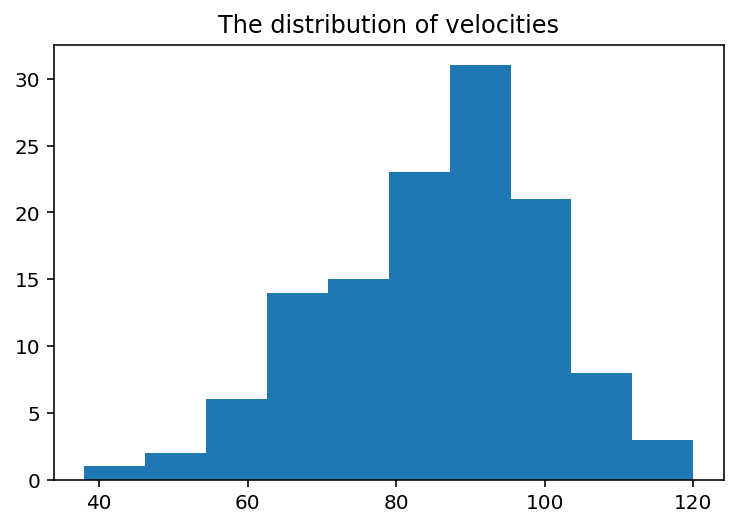

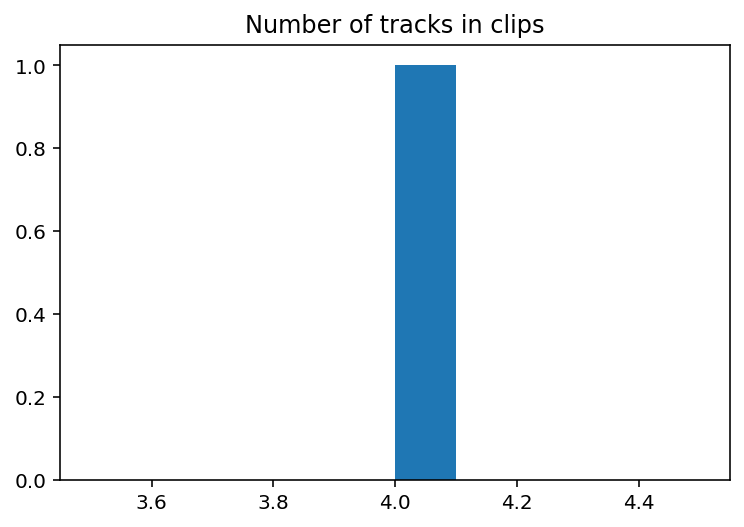

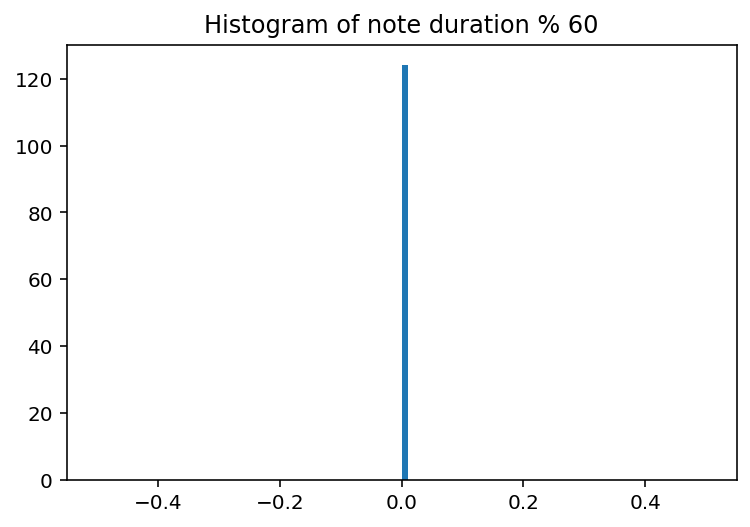

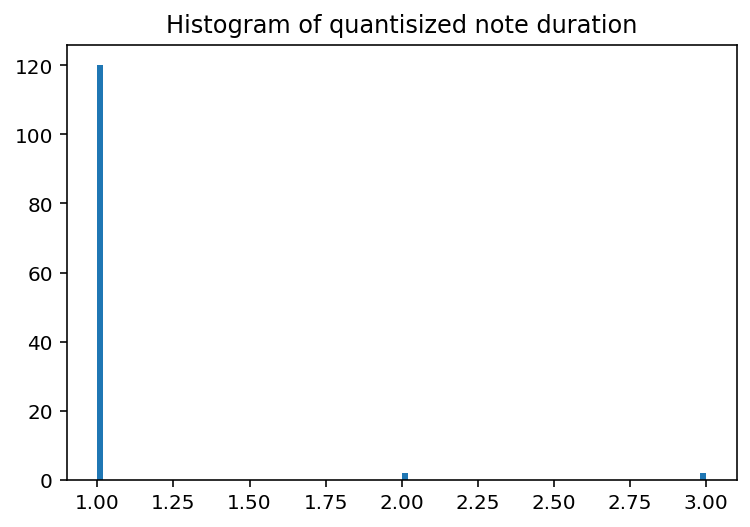

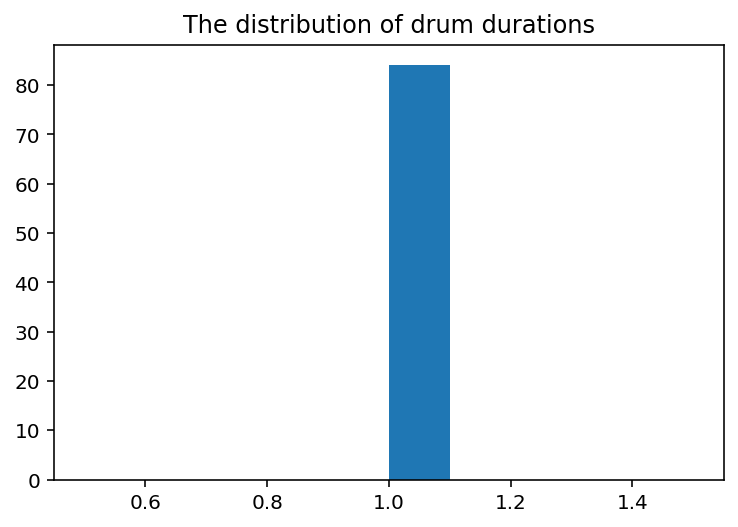

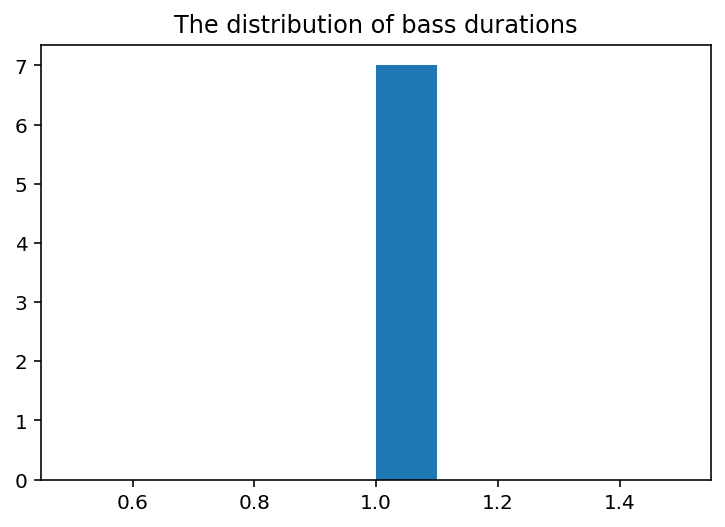

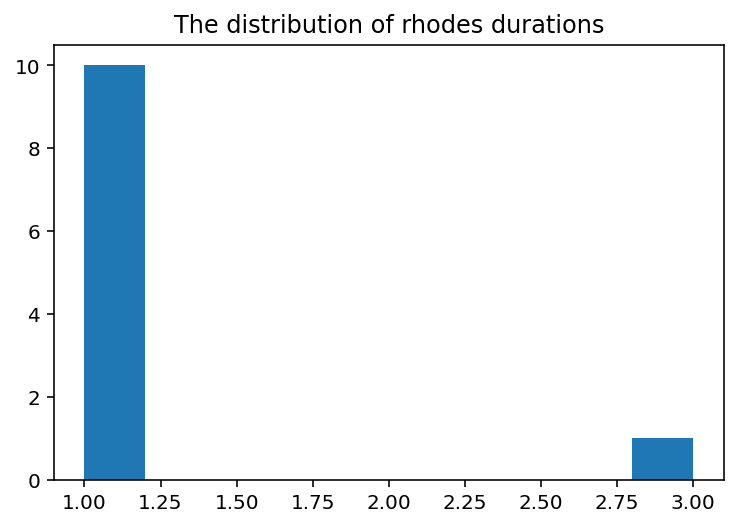

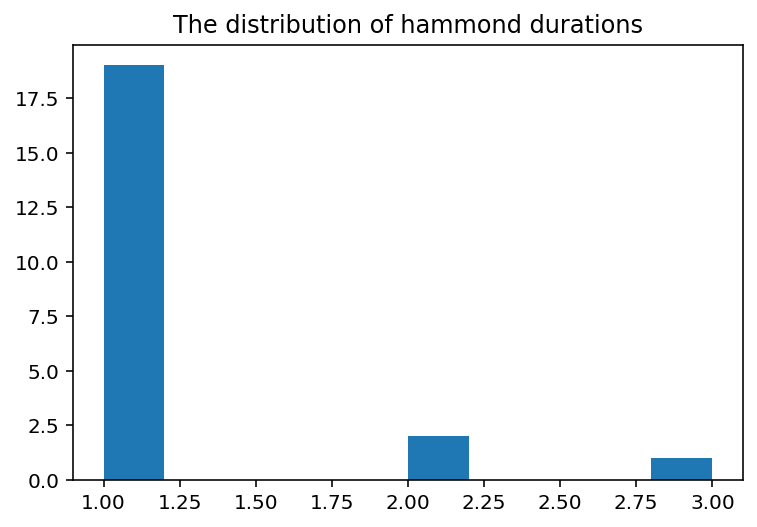

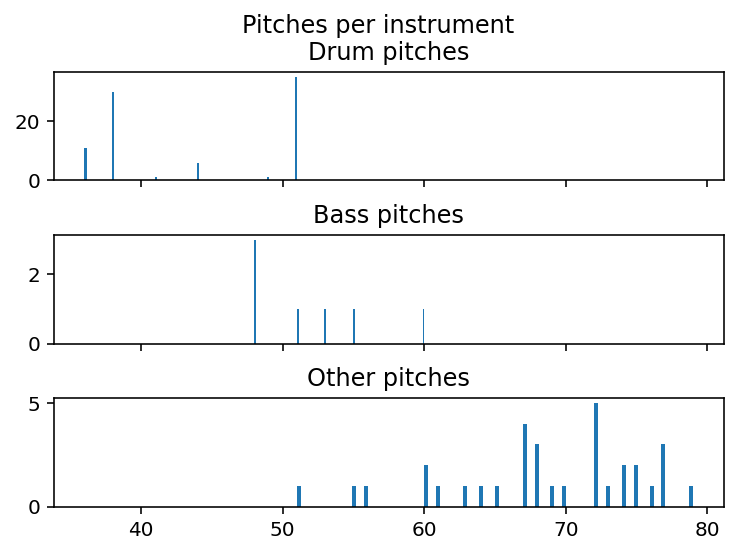

79


In [ ]:
# PLOT HISTOGRAM OF THE GENERATED MUSPY OBJ
muspy_obj = post_process(clip_ret,0)
create_hist([muspy_obj])

In [ ]:
# RUN ABOVE FIRST IF COMMENTED
#muspy_obj = post_process(clip_ret,0)
print(muspy_obj.tracks)
play_clip(muspy_obj)

[Track(program=16, is_drum=True, notes=[Note(time=760320, pitch=36, duration=60, velocity=117), Note(time=760320, pitch=39, duration=60, velocity=64), Note(time=760320, pitch=42, duration=60, velocity=99), ...]), Track(program=39, is_drum=False, notes=[Note(time=760740, pitch=48, duration=60, velocity=86), Note(time=761460, pitch=43, duration=60, velocity=61), Note(time=761520, pitch=48, duration=60, velocity=79), ...]), Track(program=4, is_drum=False, notes=[Note(time=760320, pitch=36, duration=60, velocity=73), Note(time=760320, pitch=60, duration=60, velocity=95), Note(time=760680, pitch=67, duration=60, velocity=65), ...]), Track(program=17, is_drum=False, notes=[Note(time=760320, pitch=60, duration=120, velocity=90), Note(time=760320, pitch=64, duration=60, velocity=102), Note(time=760320, pitch=67, duration=60, velocity=89), ...])]


# Interpolations and Swirls

(20,)


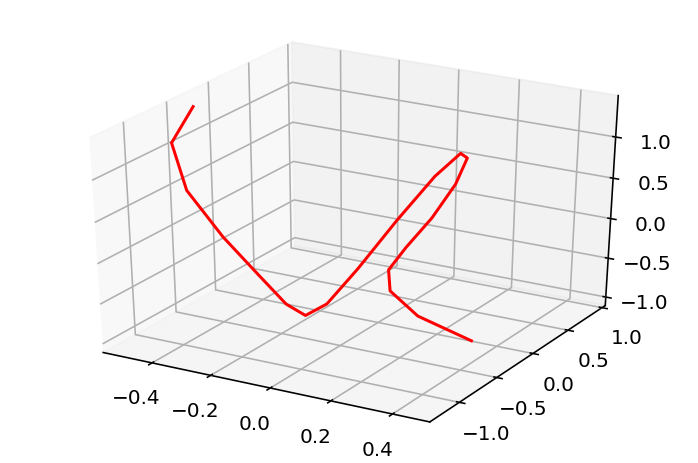

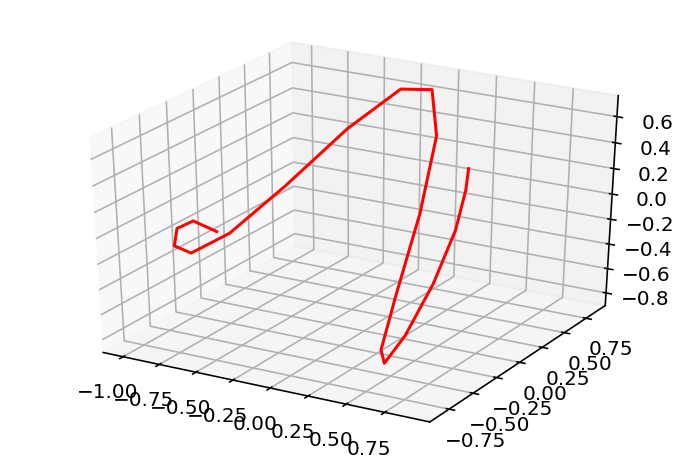

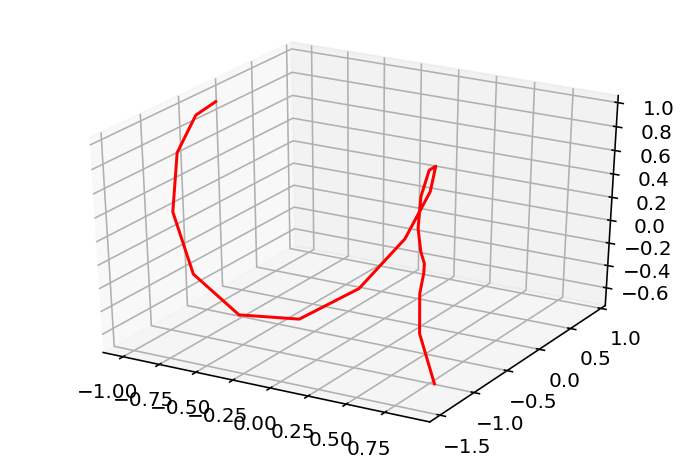

In [ ]:
# Swirls
def swirl(t,a,b,c,d):
  return np.exp(1j*a*t) - np.exp(1j*b*t)/2 + 1j*np.exp(1j*c*t)/3 + np.exp(1j*d*t)/4

def create_z(t, real, imag):
  ret = []
  for i in range(t.shape[0]):
    ret.append([t[i],real[i],imag[i]])

  return np.array(ret, dtype=np.float32)

#2,19,-20,20 the original swirl

a,b,c,d = (10,15,-15,18) 
a2,b2,c2,d2 = (-5,-6,7,-8) 
a3,b3,c3,d3 = (4,2,8,-4)

t1 = np.arange(-0.5,0.5,0.05)
t2 = np.arange(-1,1,0.10)
t3 = np.arange(-1,1,0.10)

print(t1.shape)

z1 = swirl(t1,a,b,c,d)
z2 = swirl(t2,a2,b2,c2,d2)
z3 = swirl(t3,a3,b3,c3,d3)

real1 = z1.real 
imag1 = z1.imag
real2 = z2.real 
imag2 = z2.imag
real3 = z3.real 
imag3 = z3.imag

#plt.plot(real,imag)
#plt.xlabel("Real")
#plt.ylabel("Imaginary")
#plt.title("The swirls")
#plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(t1, real1, imag1, 'red')
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(t2, real2, imag2, 'red')
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(t3, real3, imag3, 'red')
plt.show()

# concat to a latent vector
#print(t,real,imag)
zs1 = create_z(t1,real1,imag1)
zs2 = create_z(t2,real2,imag2)
zs3 = create_z(t3,real3,imag3)

#print(zs.dtype)

832
832
torch.Size([832, 8, 56, 128])
(832, 3)


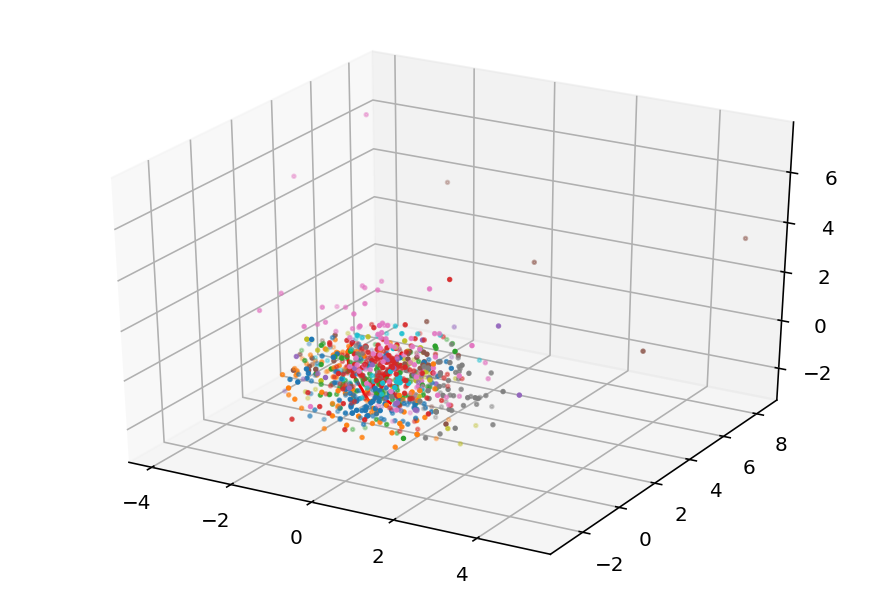

Mean = 0.003914234303430511 0.03862667559979645 0.029884264735581104


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
# Plot the latent space of the training set 
#latent_values_x = []
#latent_values_y = []
#latent_values_z = []


print(len(train_set))
print(len(train_label))
print(train_set.shape)

in_data = train_set.to(device)
batch_vec = wae_encoder_loaded(in_data).cpu().data.numpy()
#batch_vec = encoder_loaded(in_data)[0].cpu().data.numpy()

print(batch_vec.shape)  
    
latent_values_x = np.array(batch_vec[:,0].tolist())
latent_values_y = np.array(batch_vec[:,1].tolist())
latent_values_z = np.array(batch_vec[:,2].tolist())

fig = pyplot.figure()
ax = Axes3D(fig)

# 'Soul_Brown', 'Soul_Neo', 'Funk_Storm', 'Soul_Tears'

#for i,label in enumerate(train_label):
#  if label=="Soul_Brown":
#    ax.scatter(latent_values_x[i], latent_values_y[i], latent_values_z[i], label=label, c="r")
#  elif label=="Soul_Neo":
#    ax.scatter(latent_values_x[i], latent_values_y[i], latent_values_z[i], label=label, c="b")
#  elif label=="Funk Storm":
#    ax.scatter(latent_values_x[i], latent_values_y[i], latent_values_z[i], label=label, c="g")
#  elif label=="Soul_Tears":
#    ax.scatter(latent_values_x[i], latent_values_y[i], latent_values_z[i], label=label, c="y")

for g in np.unique(train_label):
    i = np.where(np.array(train_label) == g)
    ax.scatter(latent_values_x[i], latent_values_y[i], latent_values_z[i], label=g, s=1^2)
#ax.scatter(latent_values_x, latent_values_y, latent_values_z, train_label)
ax.scatter(0, 0, 0, c = 'r', marker='x')

# Comment this if you want rid of the swirl
ax.plot3D(t1, real1, imag1, 'red')

pyplot.show()

mean_x = np.mean(latent_values_x)
mean_y = np.mean(latent_values_y)
mean_z = np.mean(latent_values_z)
print("Mean =", mean_x, mean_y, mean_z)

In [ ]:
# generate full clips
all_muspy_obj = []
flag = 0 
decoder_loaded = wae_decoder_loaded
#decoder_loaded = decoder_loaded

for idx,z in tqdm(enumerate(zs1)):
  z_t = torch.tensor(z).to(device)
  clip,_ = generate_music(decoder_loaded,z_t)
  muspy_obj = post_process(clip, (idx))
  all_muspy_obj.append(muspy_obj)

  if flag == 0:
    song = muspy_obj
    flag = 1
  else:
    for i in range(4):
      song.tracks[i].notes.extend(muspy_obj.tracks[i].notes)
  
print(len(song.tracks))


4


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.func

Max velocity: 127
Min velocity: 23
Max duration: 92
Min duration: 1
Tracks that have notes over 80 is:  2


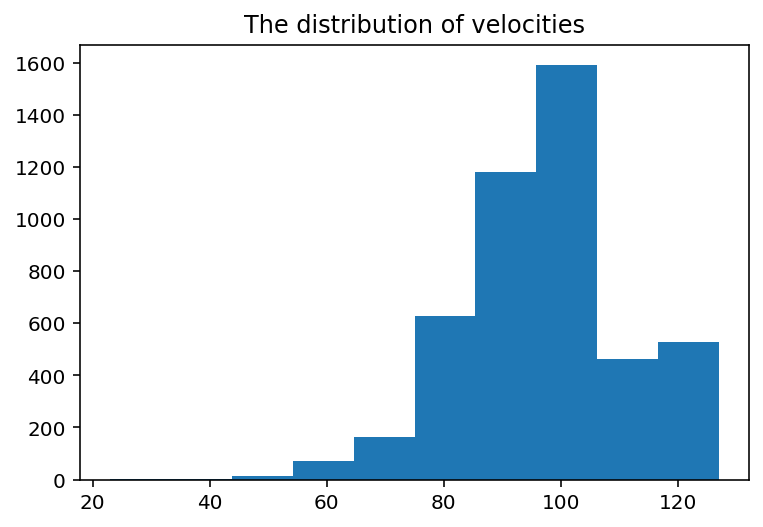

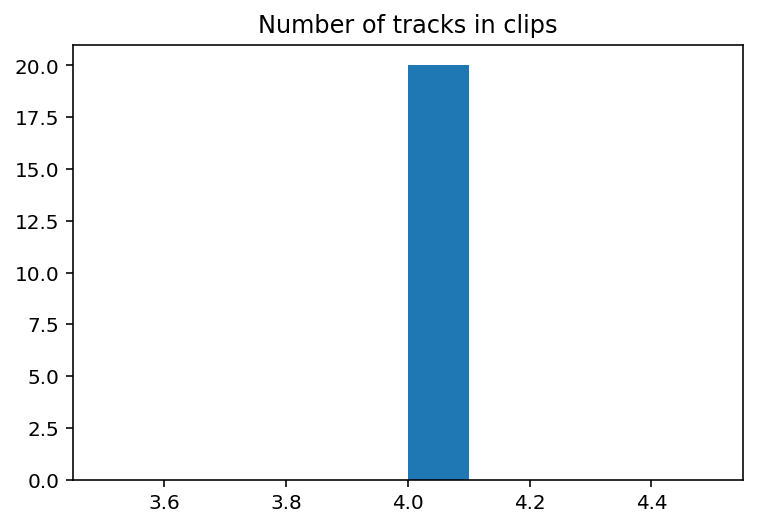

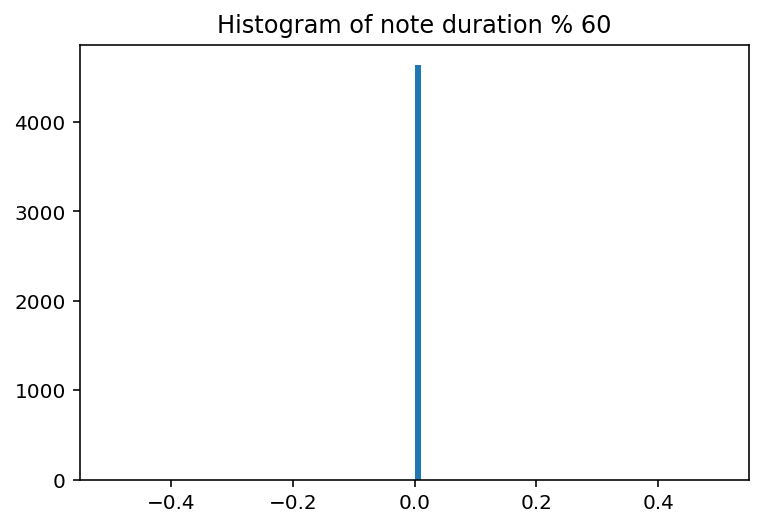

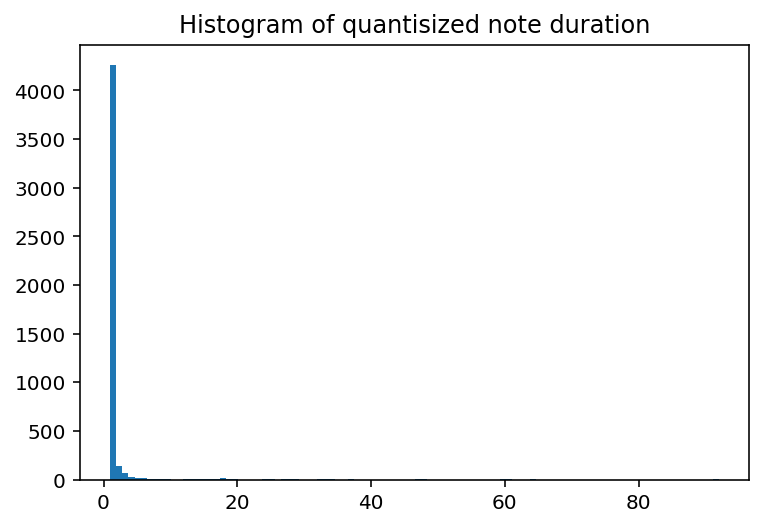

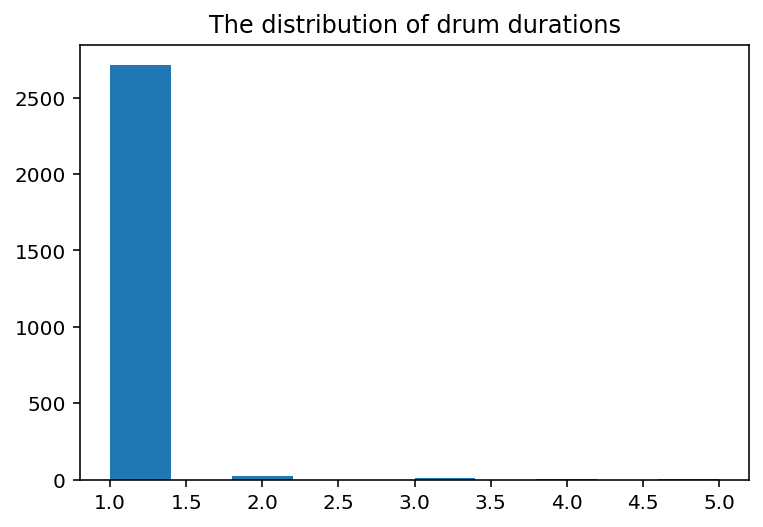

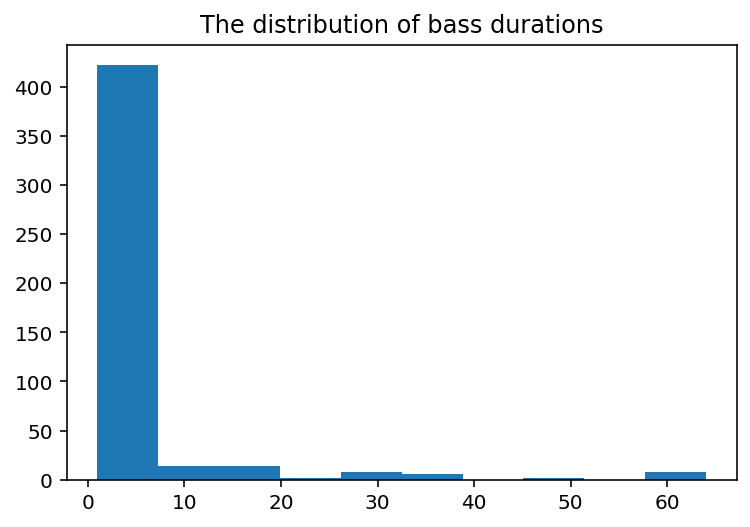

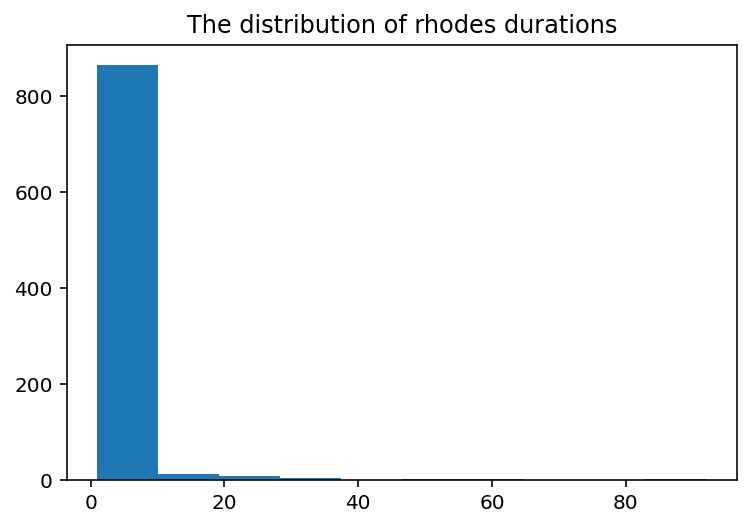

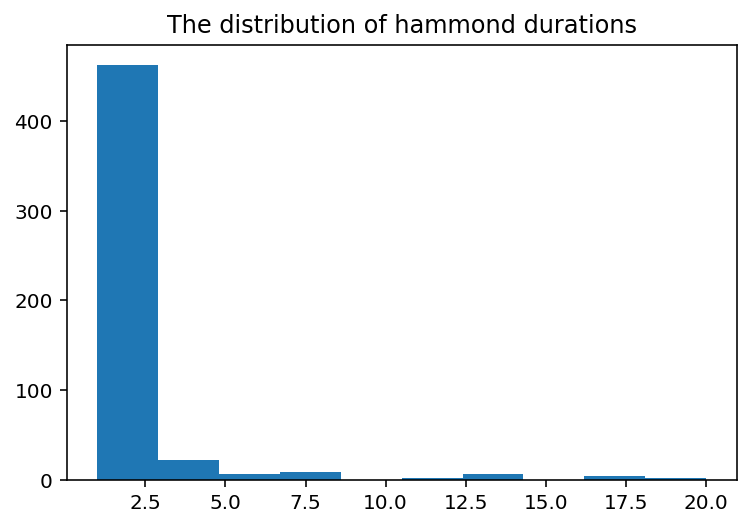

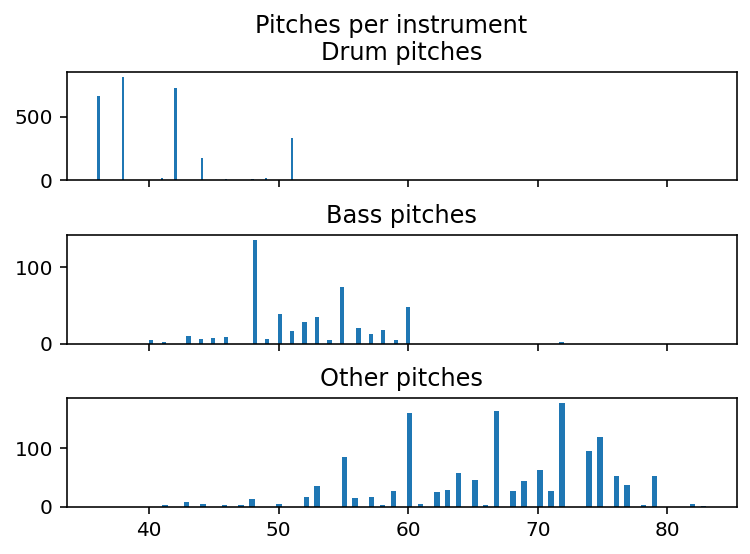

83


In [ ]:
# Print histogram of whole clip
create_hist(all_muspy_obj) 

In [ ]:
print(song)
print((song.tracks[0].notes))

print(len(song.tracks[0].notes))
play_clip(song)

Music(metadata=Metadata(schema_version='0.0'), resolution=480, tracks=[Track(program=16, is_drum=True, notes=[Note(time=0, pitch=36, duration=60, velocity=108), Note(time=0, pitch=42, duration=60, velocity=100), Note(time=240, pitch=42, duration=60, velocity=90), ...]), Track(program=39, is_drum=False, notes=[Note(time=0, pitch=43, duration=60, velocity=99), Note(time=0, pitch=48, duration=60, velocity=87), Note(time=360, pitch=43, duration=60, velocity=92), ...]), Track(program=4, is_drum=False, notes=[Note(time=0, pitch=43, duration=120, velocity=106), Note(time=0, pitch=48, duration=60, velocity=89), Note(time=0, pitch=55, duration=180, velocity=105), ...]), ...])
[Note(time=0, pitch=36, duration=60, velocity=108), Note(time=0, pitch=42, duration=60, velocity=100), Note(time=240, pitch=42, duration=60, velocity=90), Note(time=360, pitch=42, duration=60, velocity=87), Note(time=480, pitch=38, duration=60, velocity=91), Note(time=480, pitch=42, duration=60, velocity=122), Note(time=72